This notebook is for analyzing absorption lines in the KELT-9b_20180703_PEPSI dataset.

# Imports

In [6]:
import glob
import os
os.chdir('/home/paiasnodkar.1/AtmosphericDynamics/')

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.io.fits as FITS
from astropy.coordinates import SkyCoord

import importlib

import TransmissionSpectroscopy_lib_unity as TSL

# Read in observations

Initialize FluxMap object

In [7]:
# Data set labels
planet_name = 'KELT-9b_20180703_PEPSI'
planet_name_ref = 'KELT-9b'
config_filename = 'planet_configs/'+planet_name_ref+'_config.txt'

# Initialize FluxMap object with system parameters
FM = TSL.FluxMap(config_filename)

Add observations to FluxMap object

In [8]:
# Define data directory and compile list of observation files
data_dir = 'data/'+planet_name_ref+'/'+planet_name+'/pepsib.20180703.*.dxt.avr'
dirFiles = glob.glob(data_dir)
dirFiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# Read in and add each observation to FluxMap object
print('Reading in observations...')
for i, file in enumerate(dirFiles):
    print('Observation: ', i)
    # Open FITS file
    obs_file = FITS.open(file)
    
    # Read in RA, Dec, and time from header
    coord = SkyCoord(obs_file[0].header['RA'], obs_file[0].header['DEC'], unit=(u.hourangle, u.deg),
                     frame='icrs')
    ra_obs = coord.ra.degree * u.deg
    dec_obs = coord.dec.degree * u.deg
    t_obs = obs_file[0].header['JD-OBS'] # in JD_UTC
    
    # Read in spectrum
    wav_obs = obs_file[1].data["Arg"] * u.Angstrom
    flx_obs = obs_file[1].data["Fun"]
    flx_obs_err = np.sqrt(obs_file[1].data["Var"])
    
    # Add observation to FluxMap object
    FM.addNewObservation(ra_obs, dec_obs, t_obs, wav_obs, flx_obs, flx_obs_err, 'JD_UTC', False)

Reading in observations...
Observation:  0
Observation:  1
Observation:  2
Observation:  3
Observation:  4
Observation:  5
Observation:  6
Observation:  7
Observation:  8
Observation:  9
Observation:  10
Observation:  11
Observation:  12
Observation:  13
Observation:  14
Observation:  15
Observation:  16
Observation:  17
Observation:  18
Observation:  19
Observation:  20
Observation:  21
Observation:  22
Observation:  23
Observation:  24
Observation:  25
Observation:  26
Observation:  27
Observation:  28
Observation:  29
Observation:  30
Observation:  31
Observation:  32
Observation:  33
Observation:  34
Observation:  35
Observation:  36
Observation:  37
Observation:  38
Observation:  39
Observation:  40
Observation:  41
Observation:  42
Observation:  43
Observation:  44
Observation:  45
Observation:  46
Observation:  47
Observation:  48
Observation:  49
Observation:  50
Observation:  51
Observation:  52
Observation:  53
Observation:  54
Observation:  55
Observation:  56
Observation:  

# Reduce data

Clean spectra with sigma clipping and normalization; save stellar spectra

Clipping...


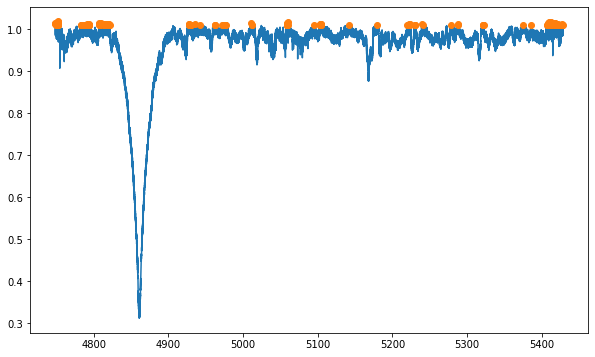

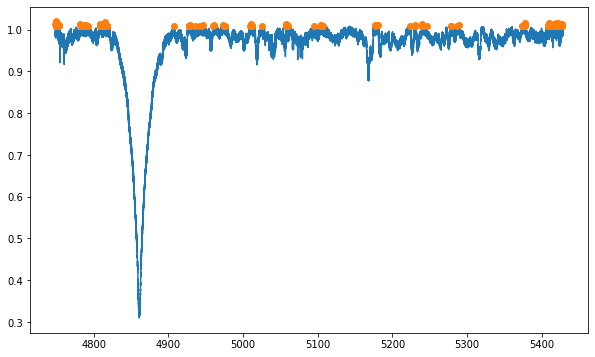

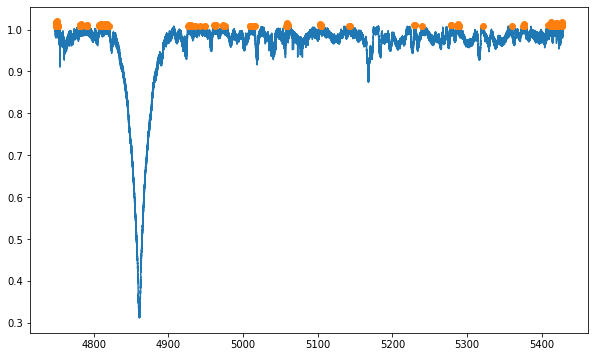

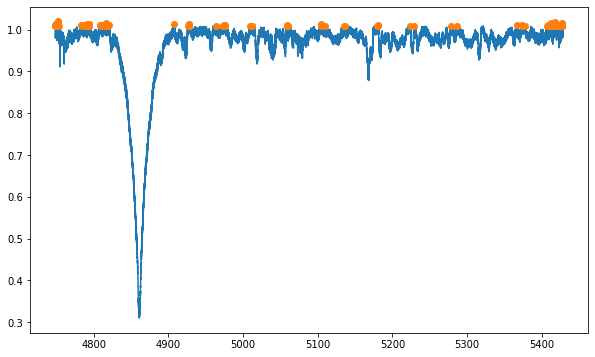

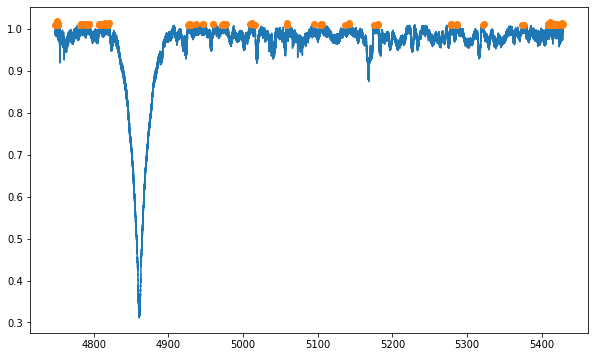

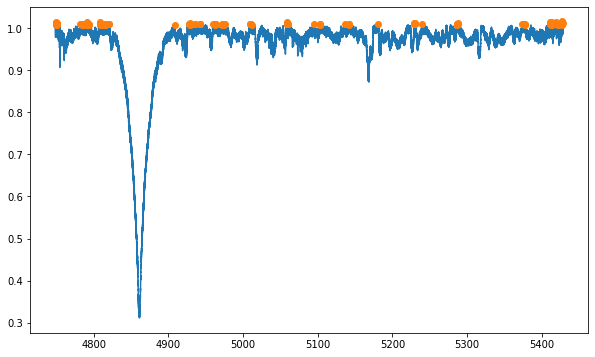

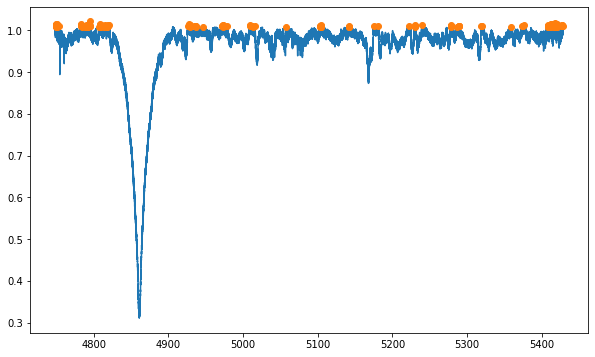

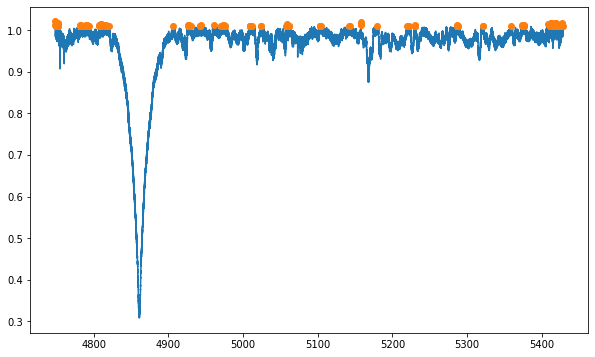

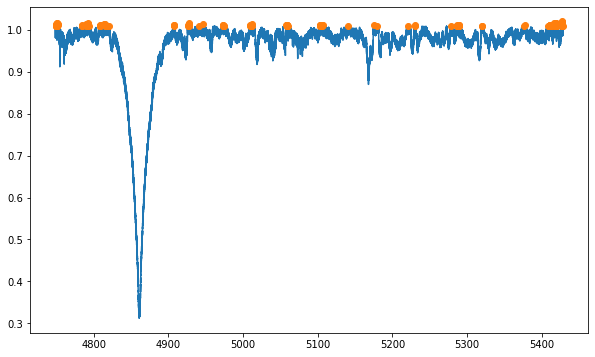

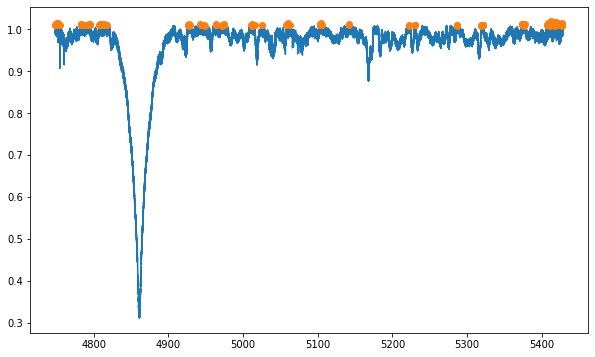

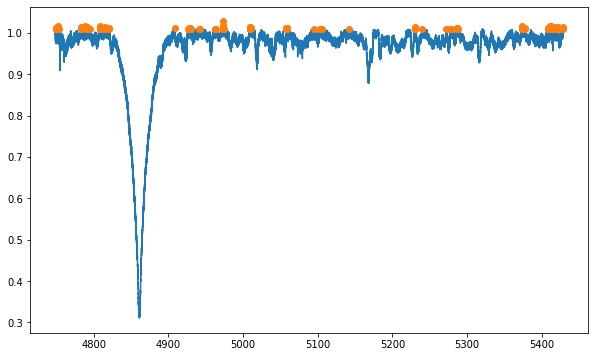

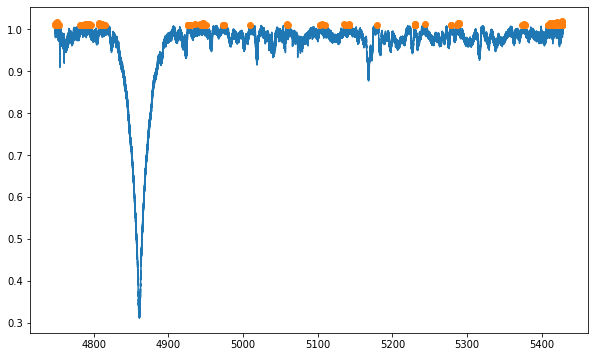

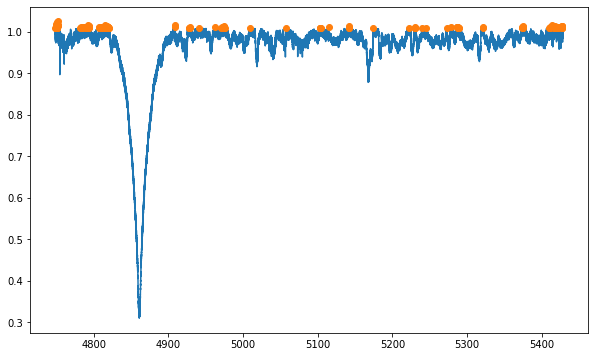

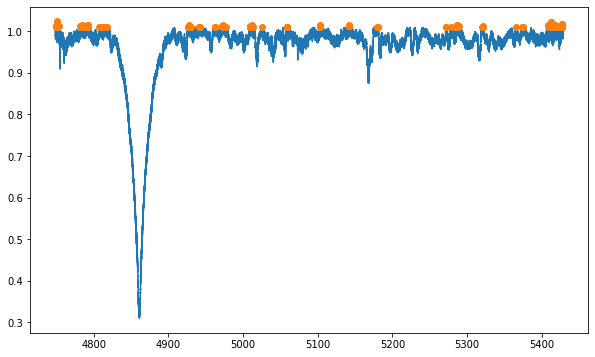

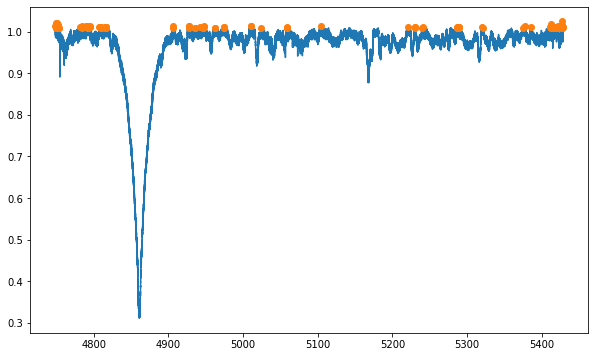

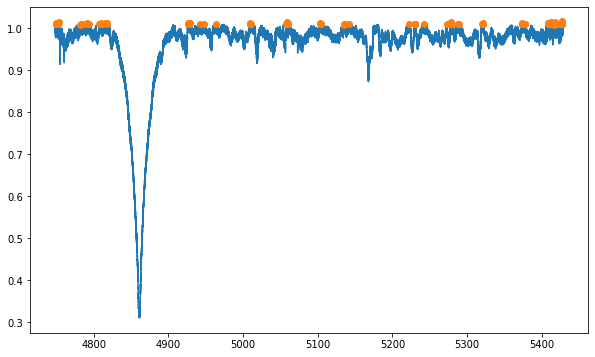

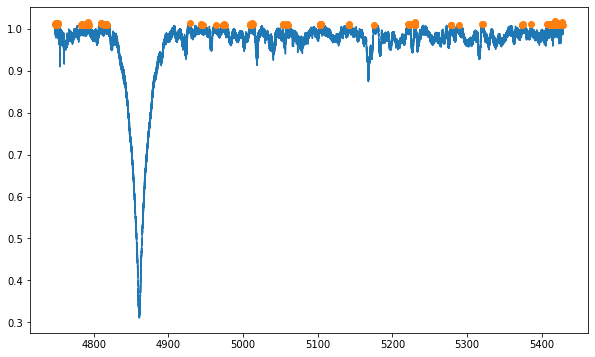

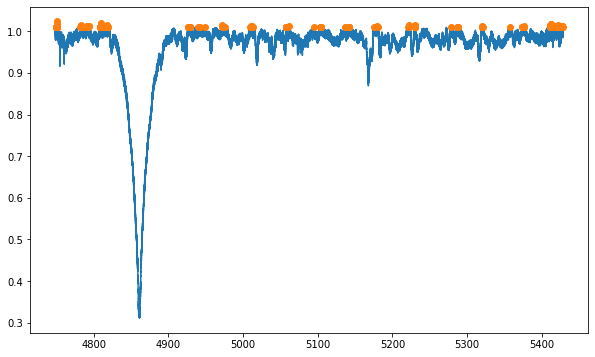

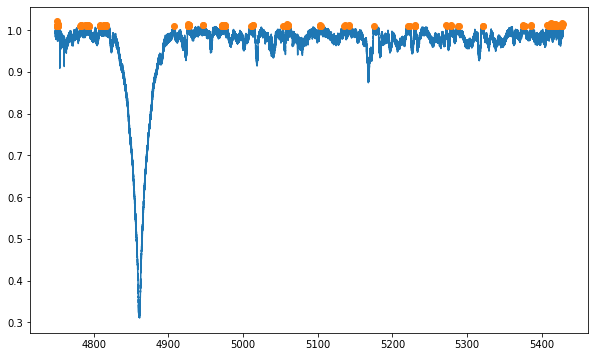

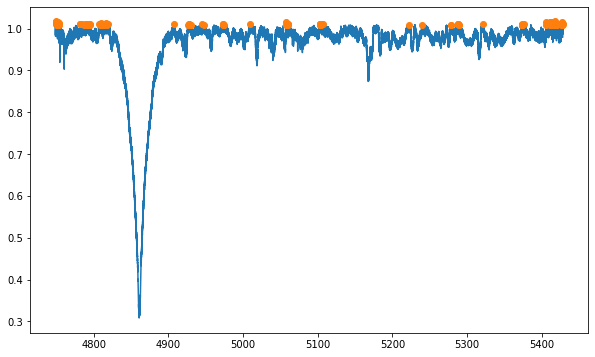

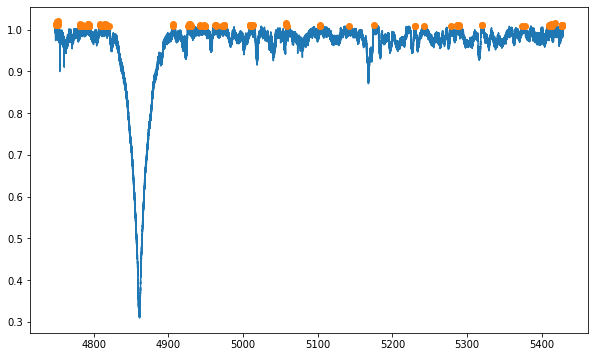

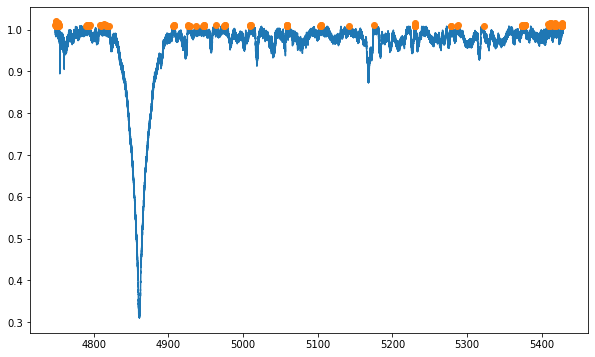

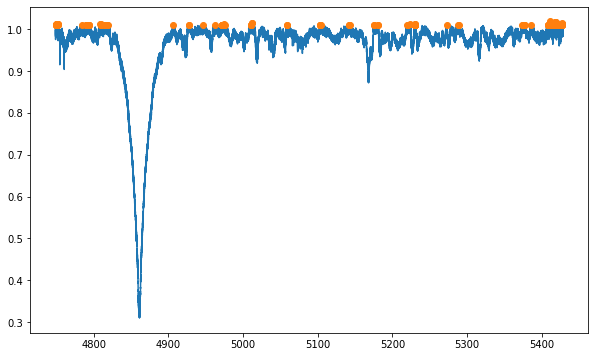

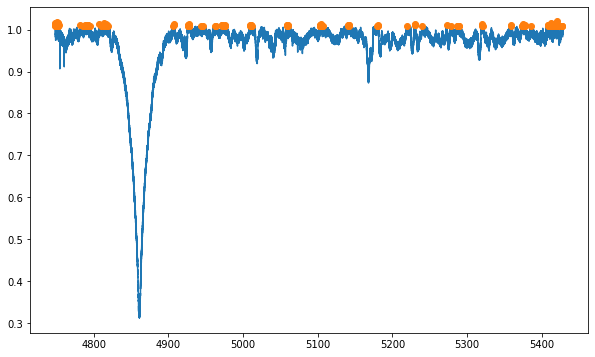

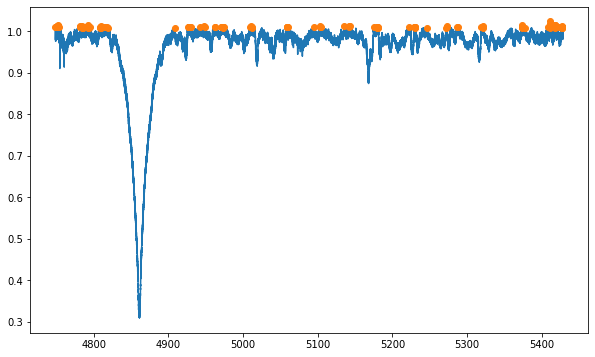

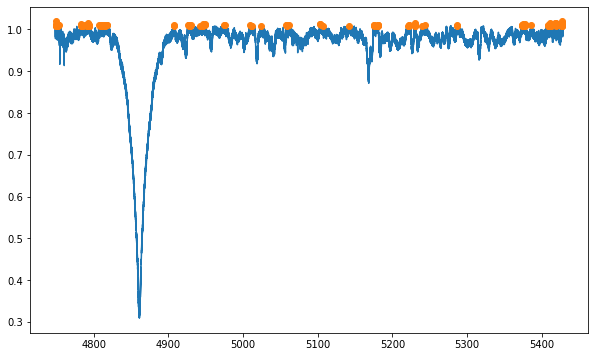

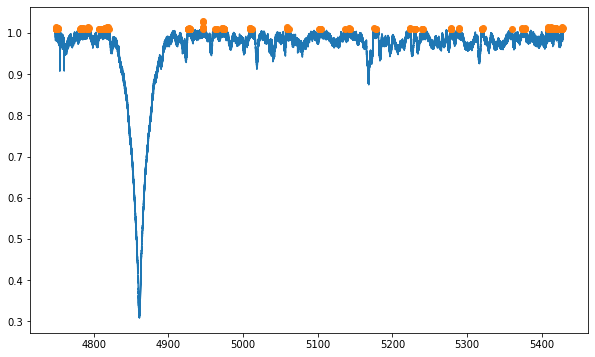

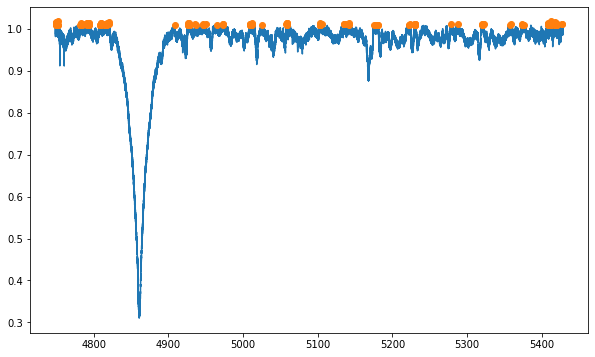

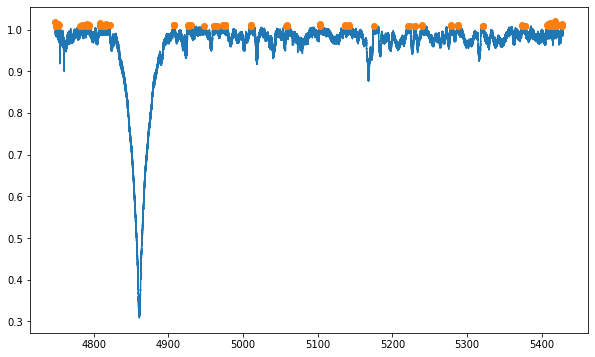

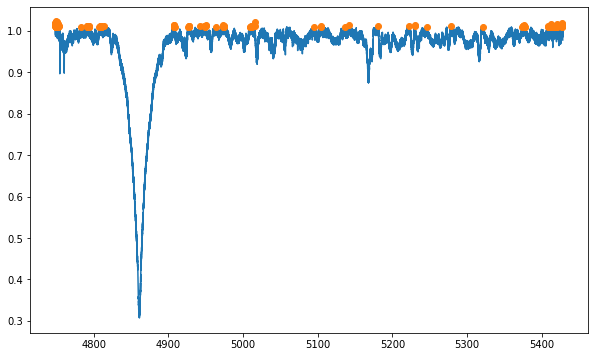

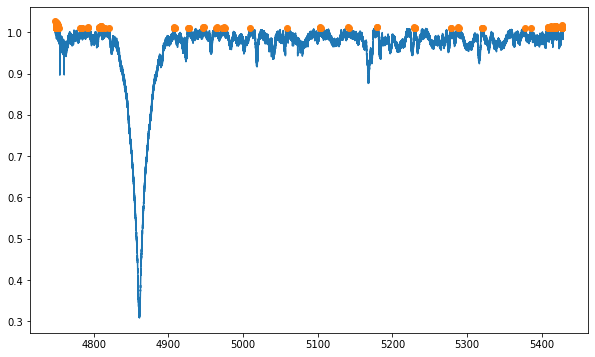

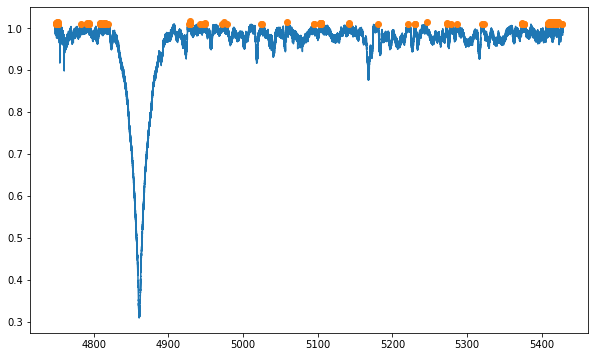

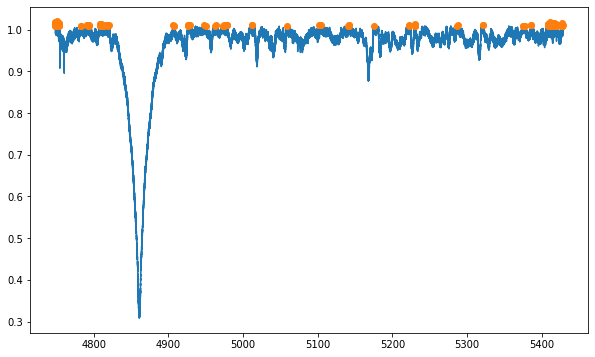

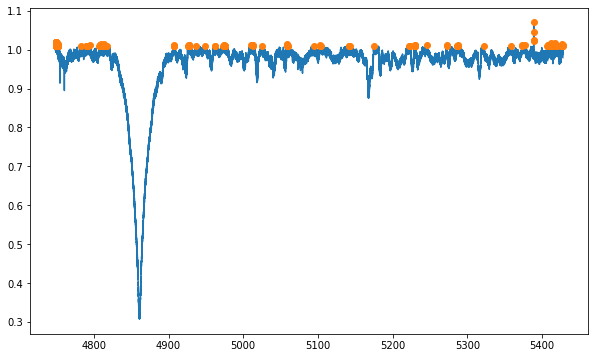

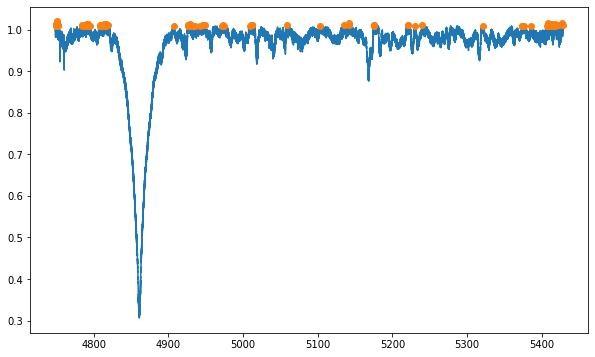

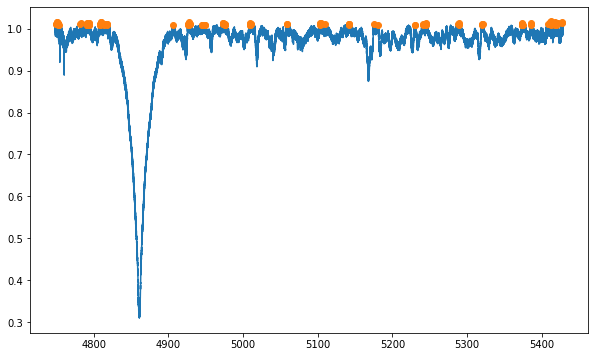

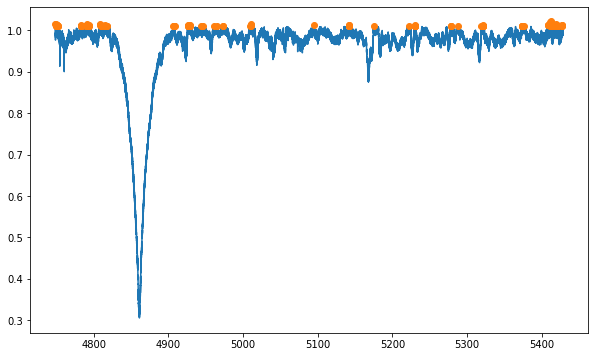

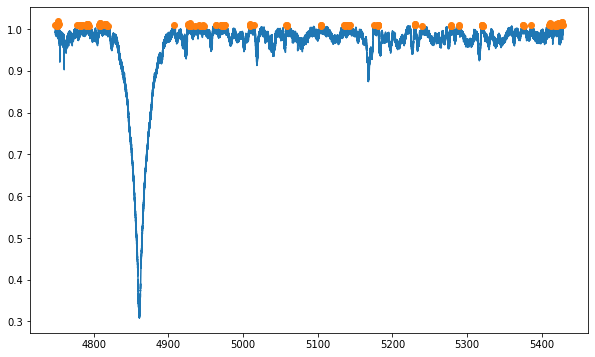

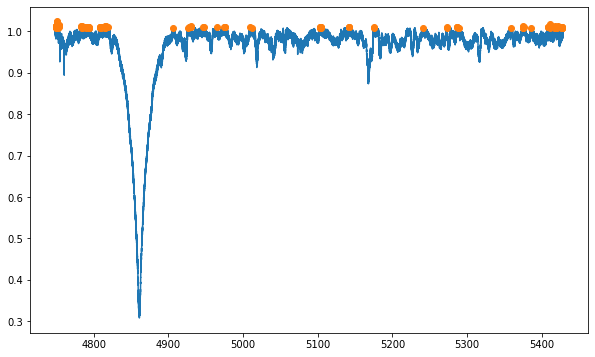

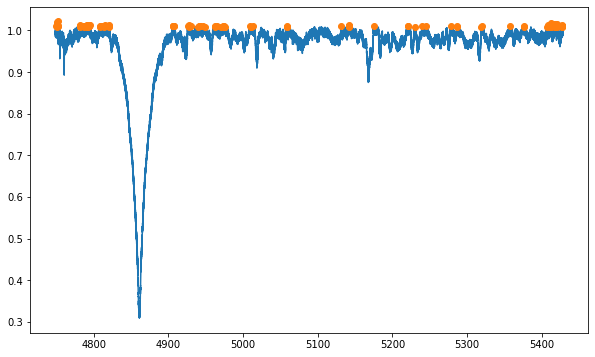

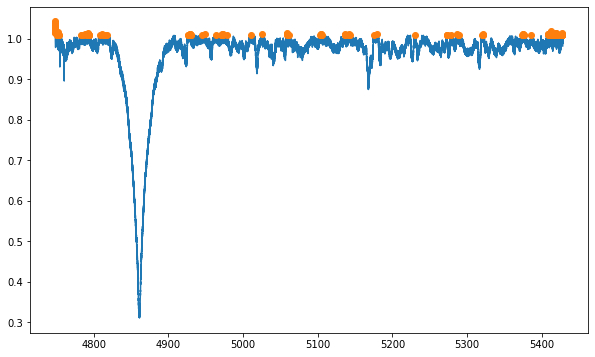

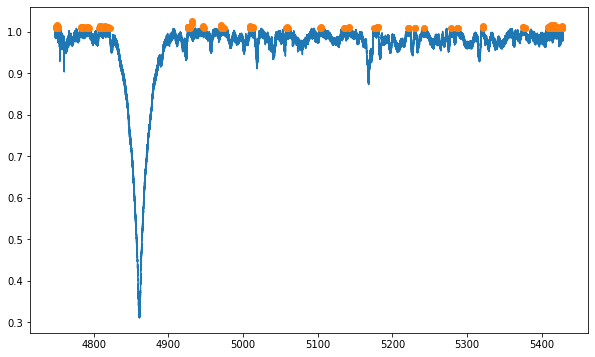

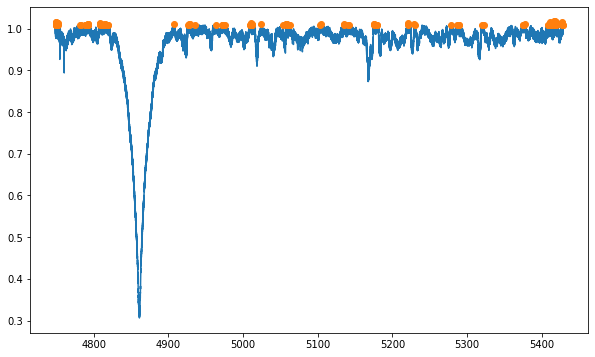

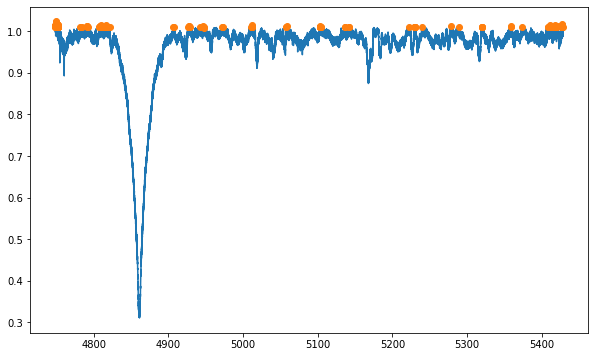

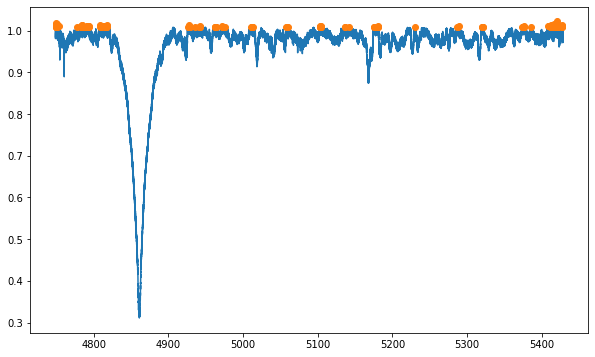

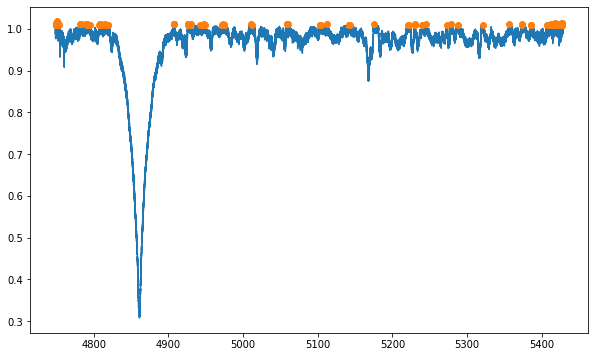

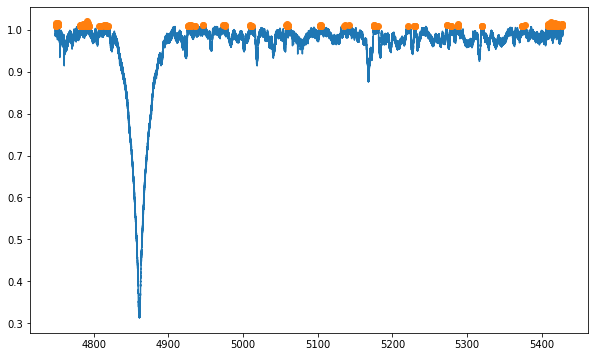

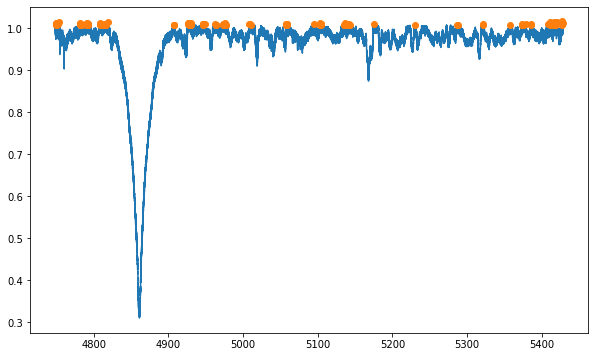

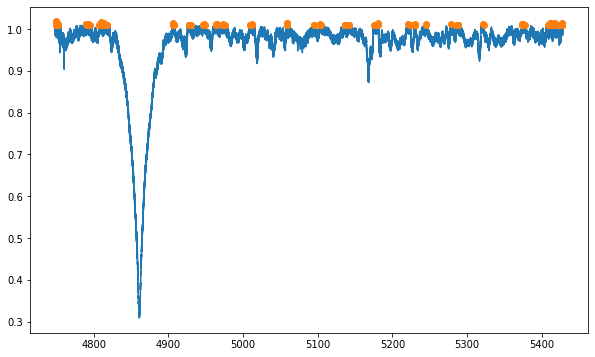

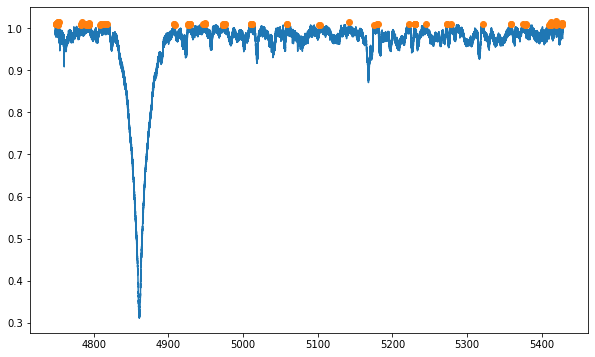

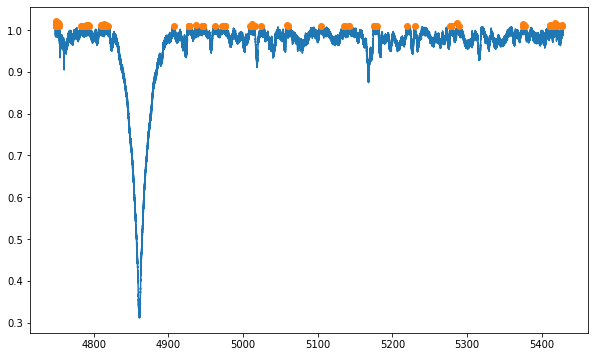

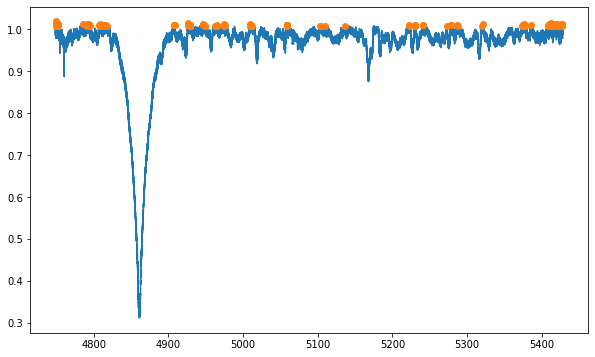

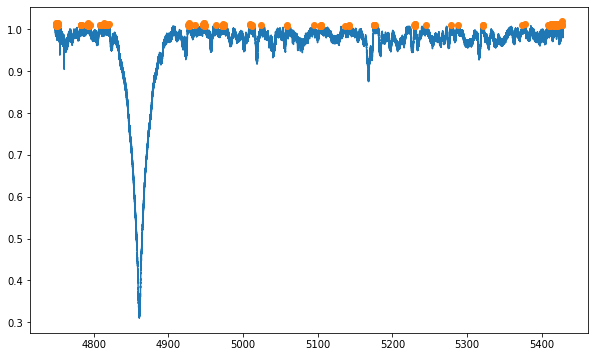

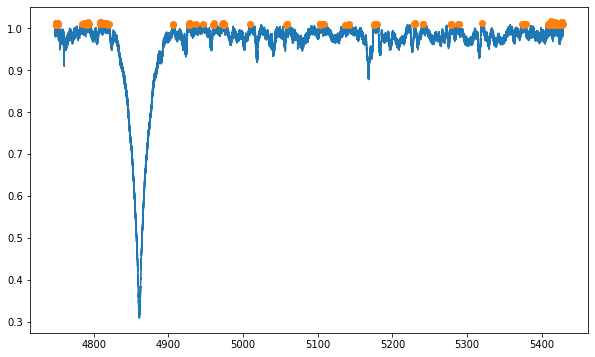

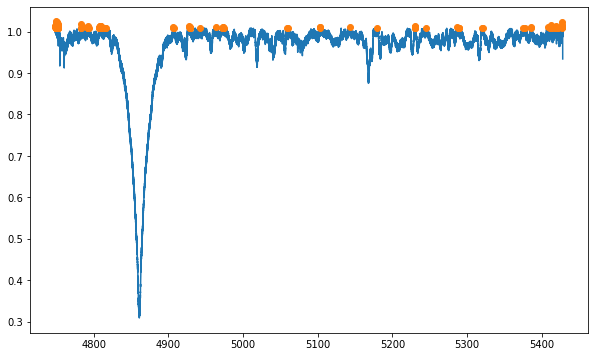

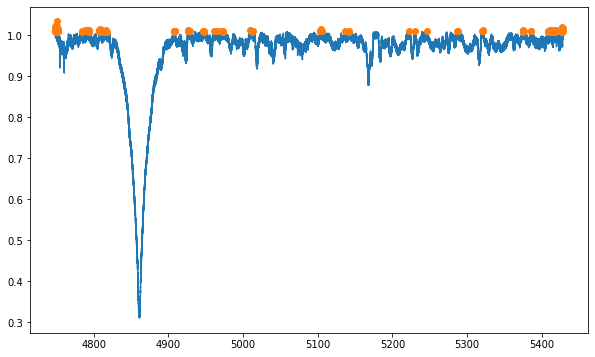

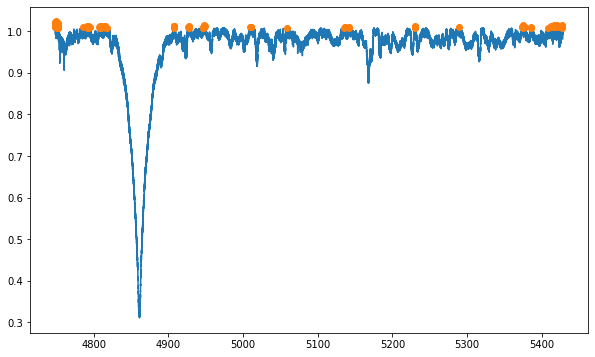

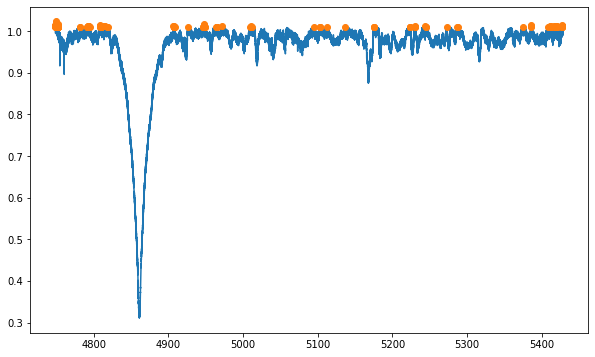

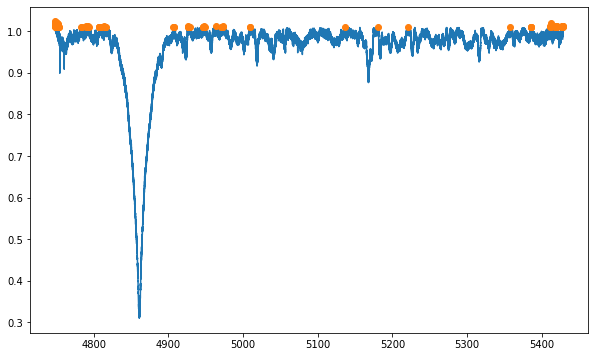

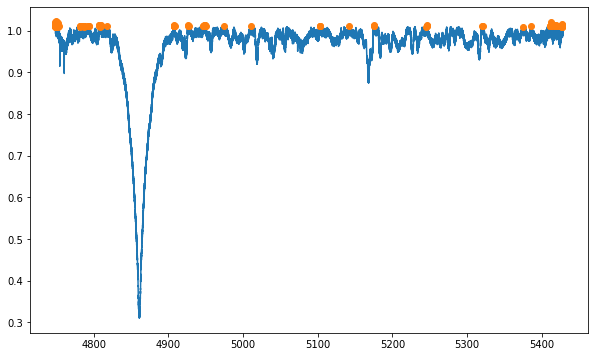

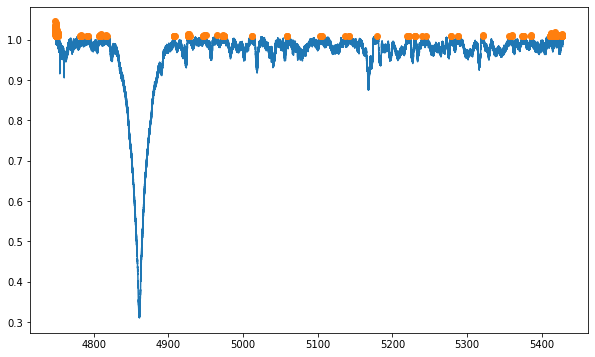

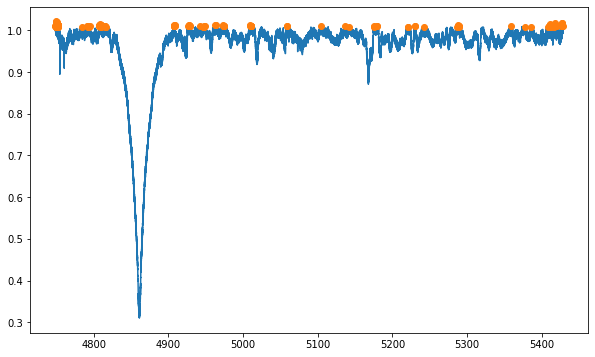

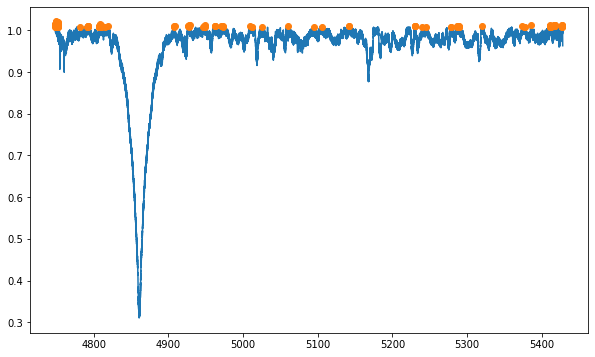

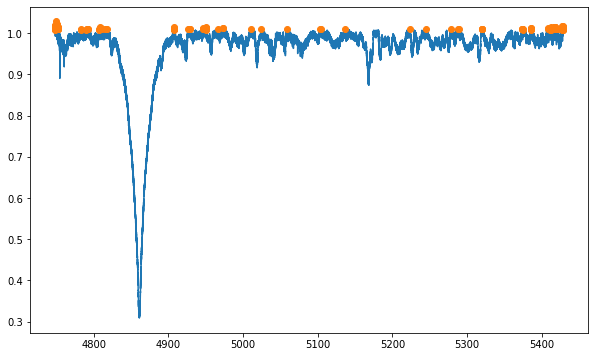

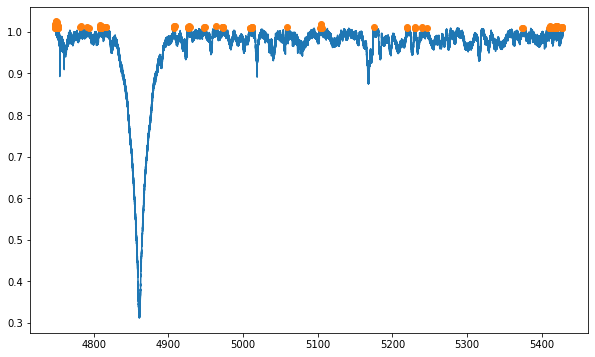

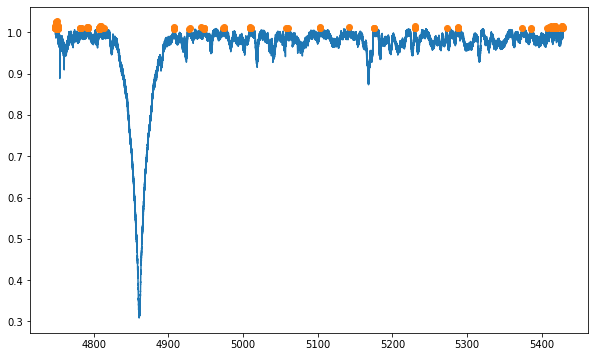

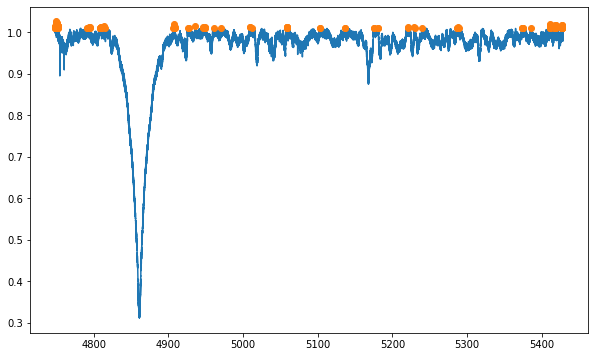

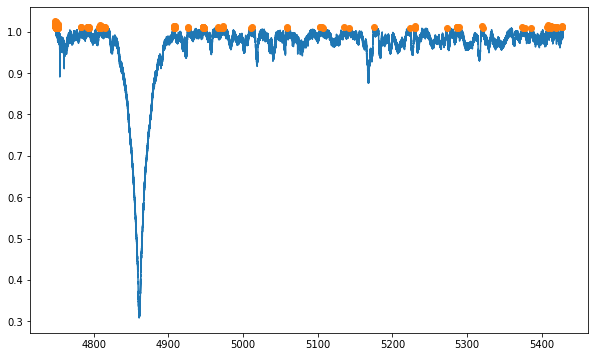

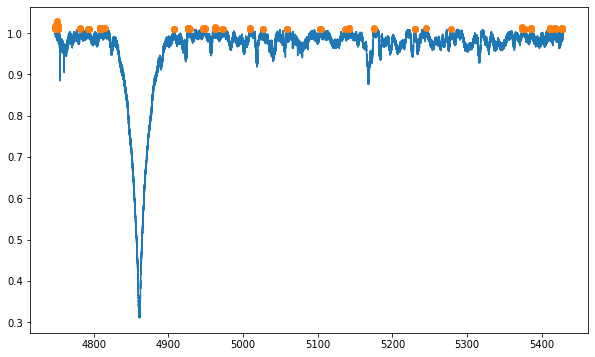

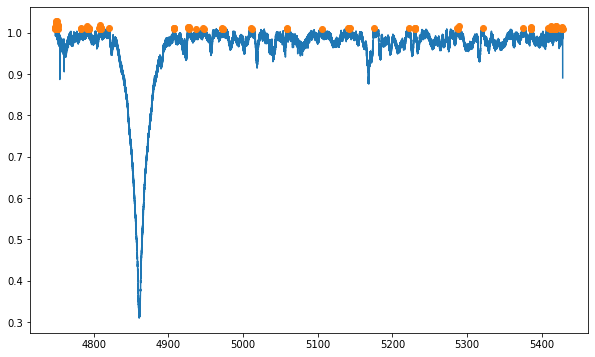

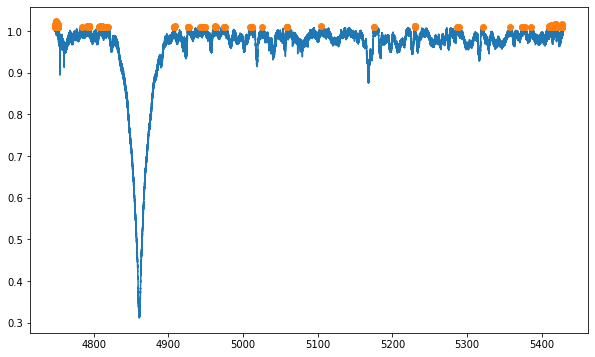

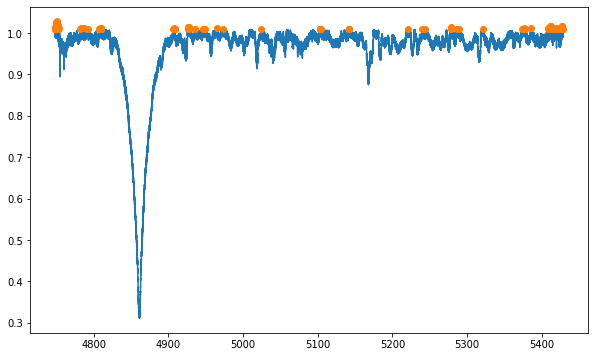

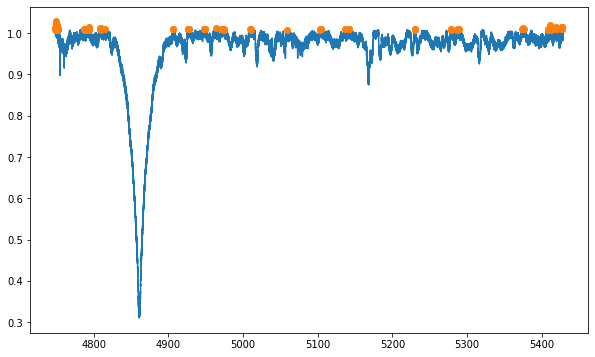

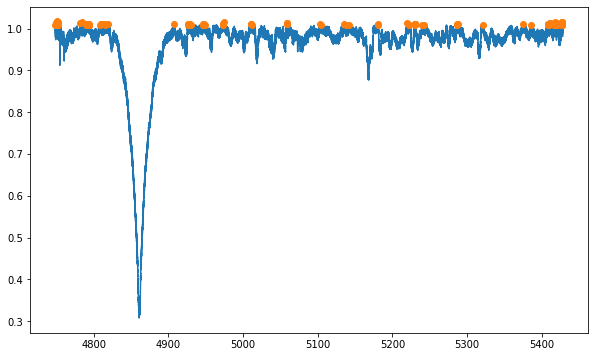

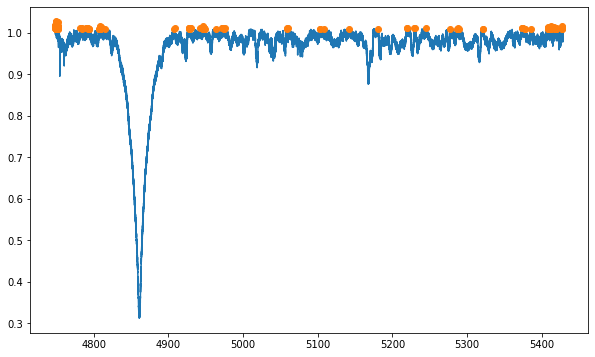

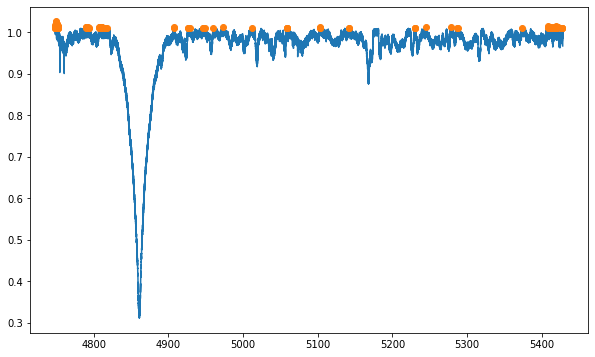

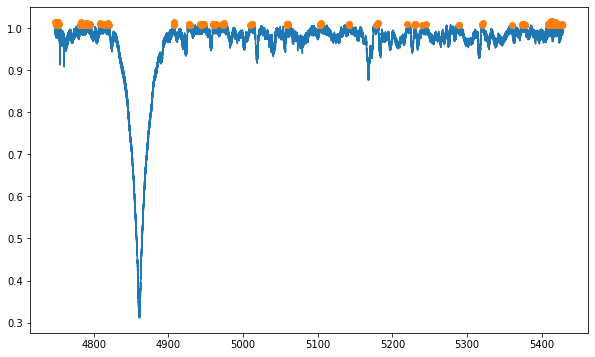

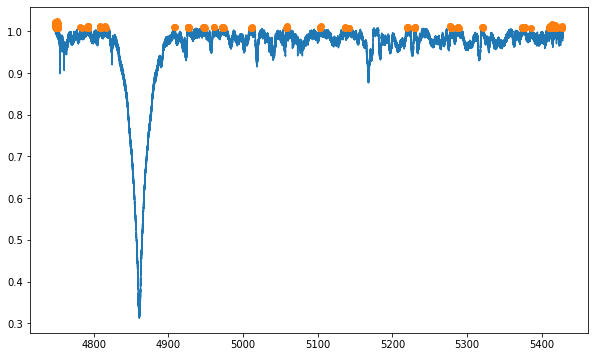

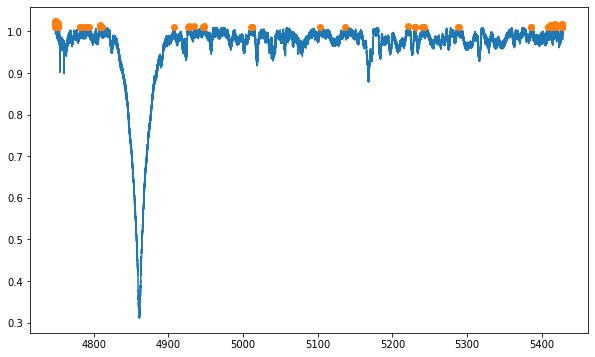

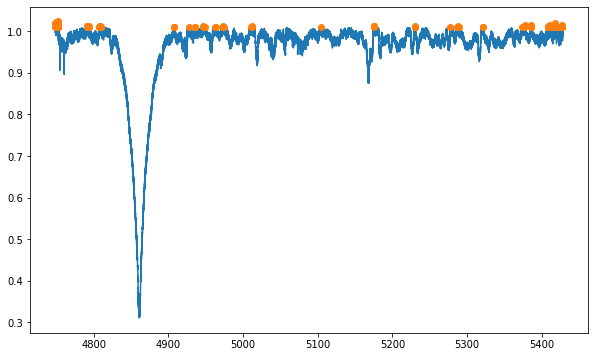

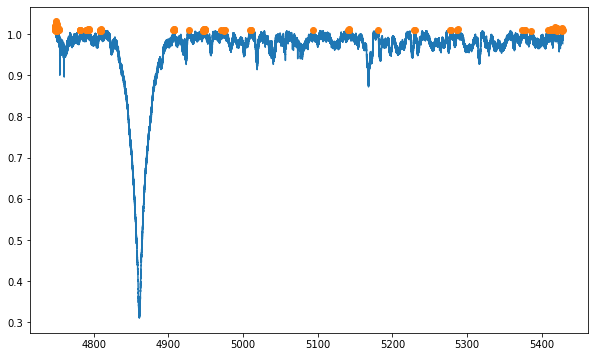

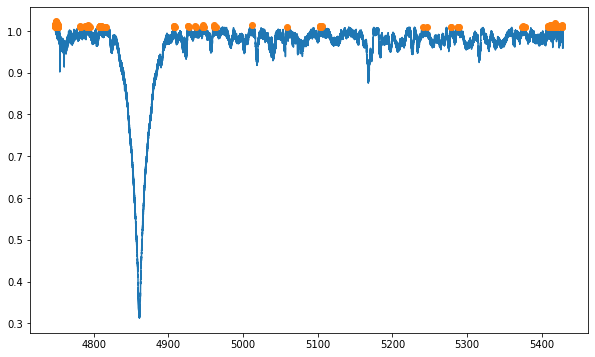

Normalizing...


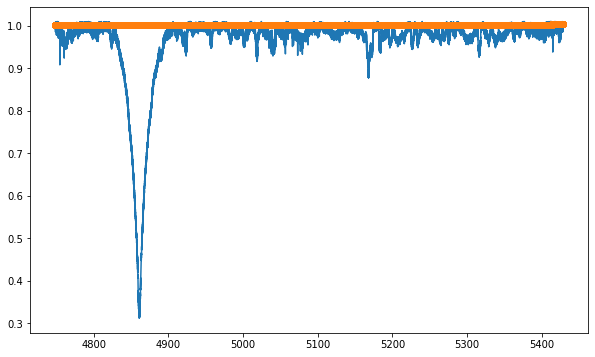

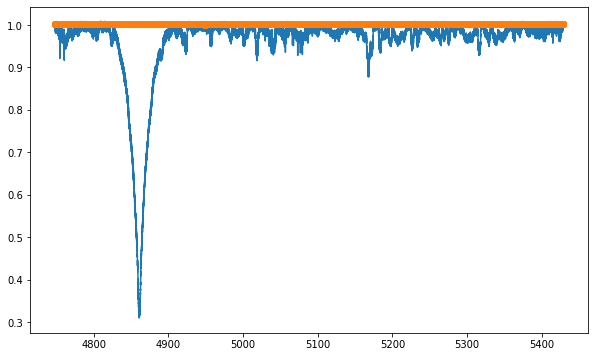

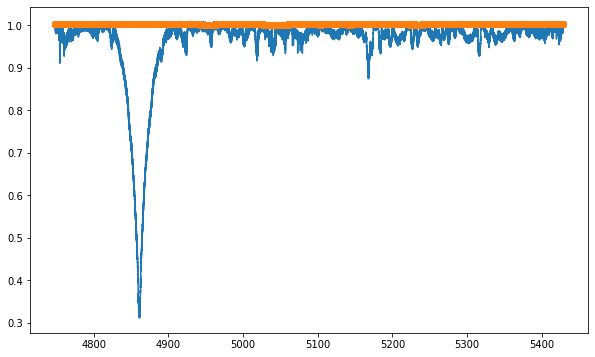

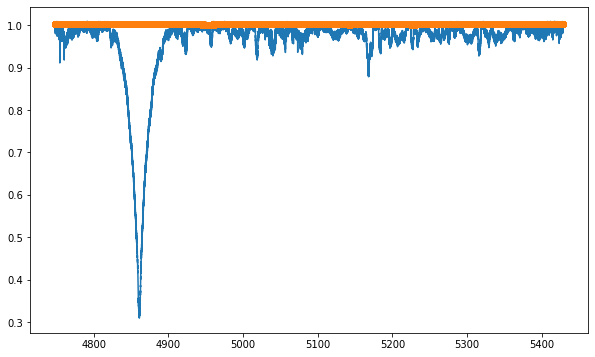

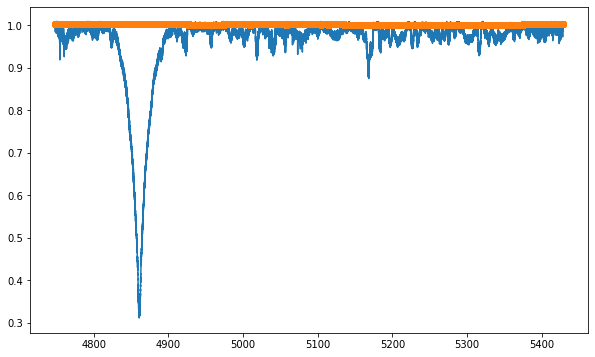

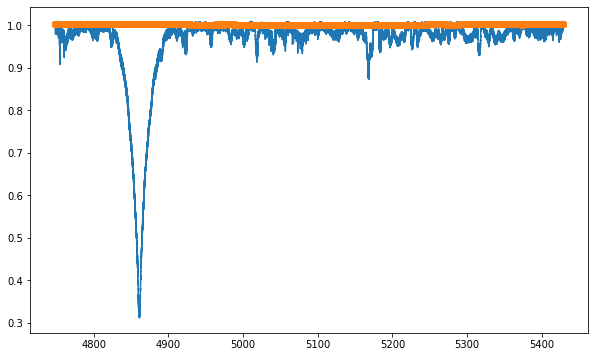

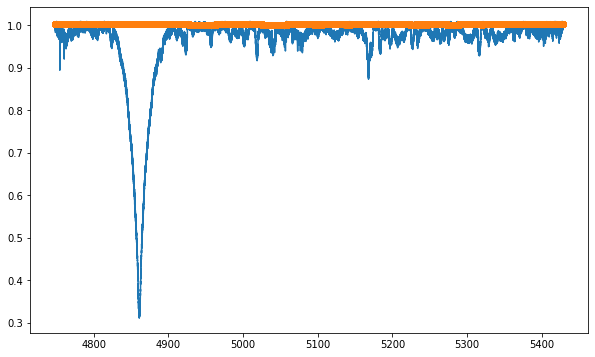

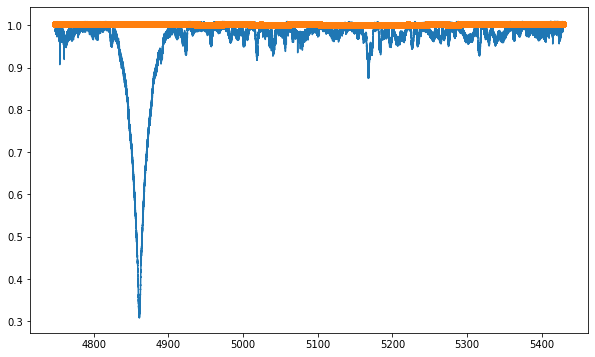

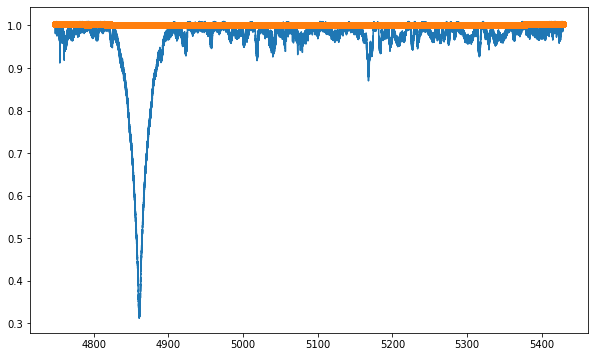

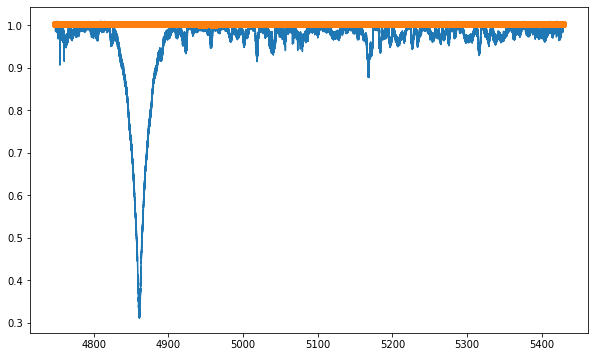

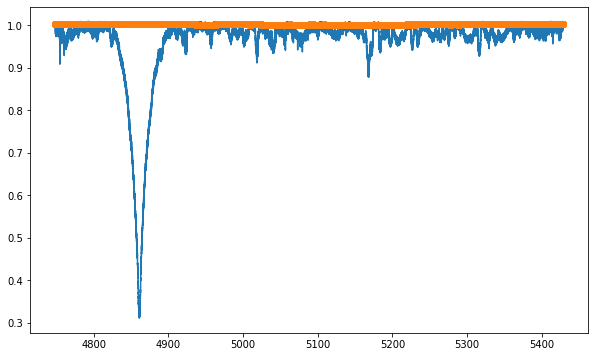

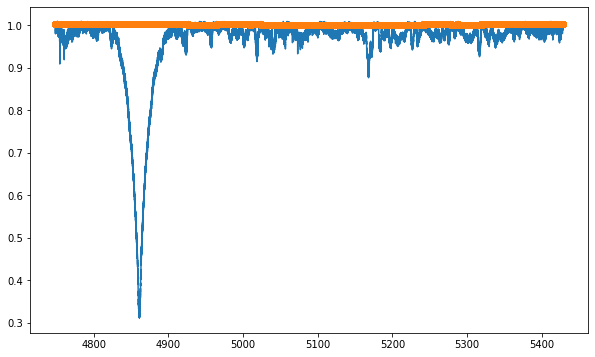

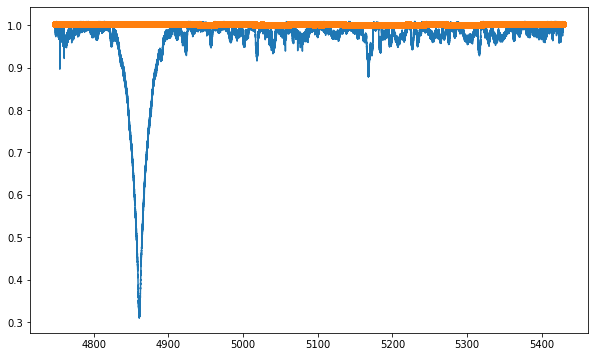

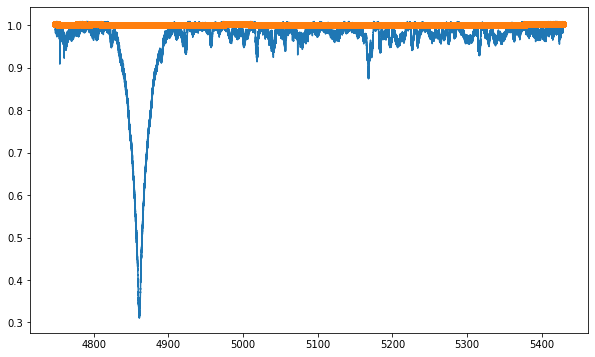

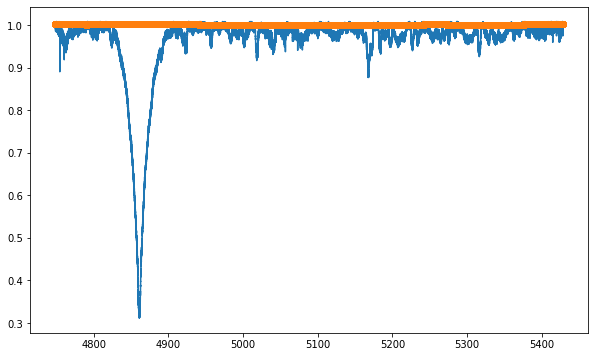

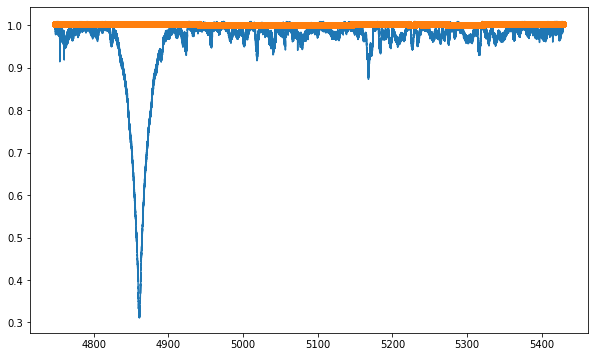

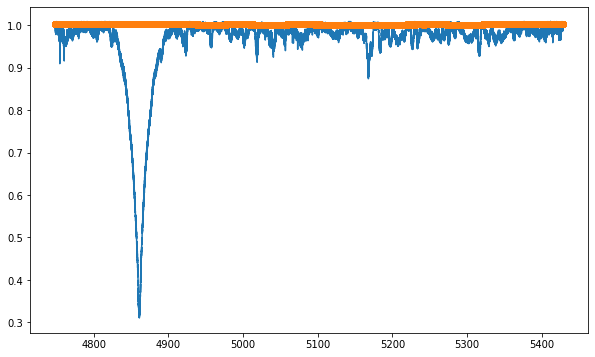

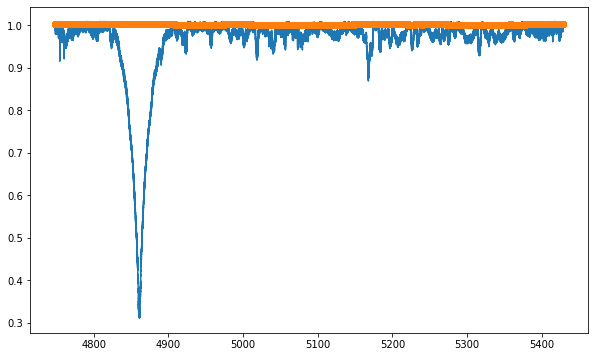

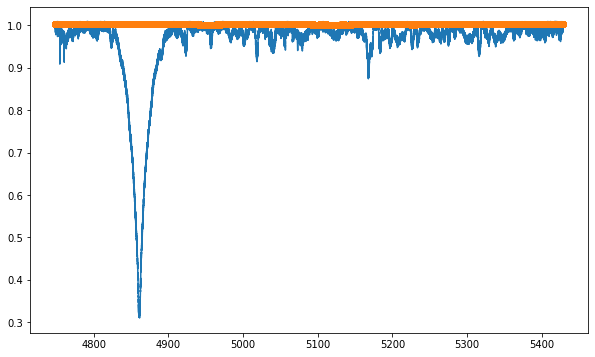

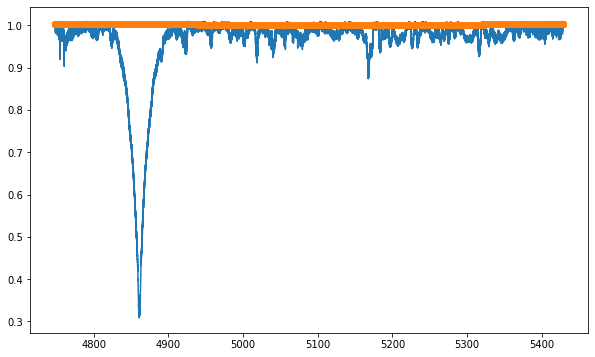

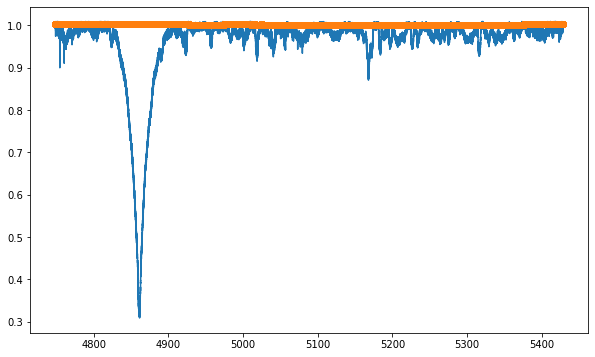

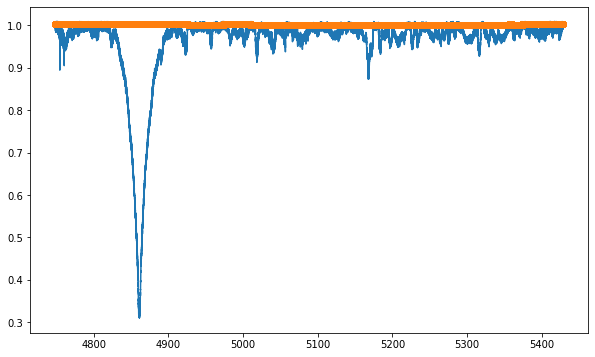

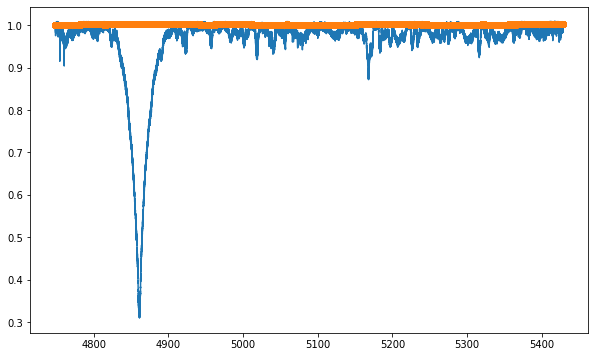

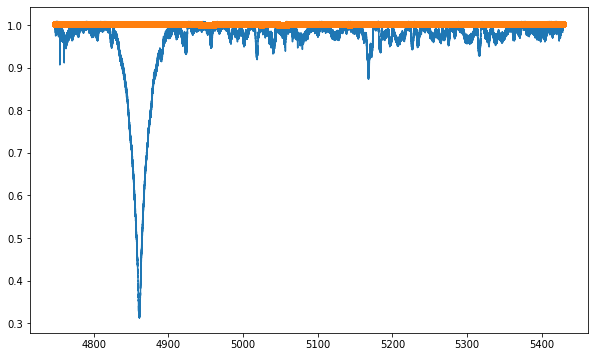

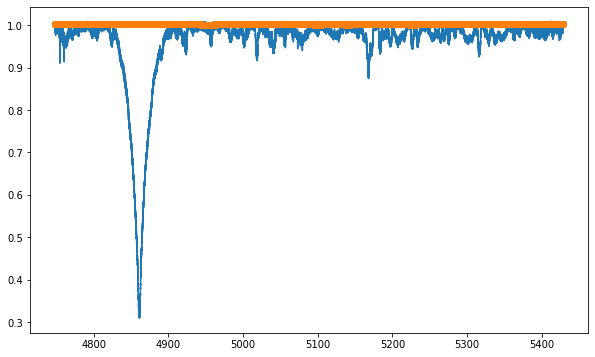

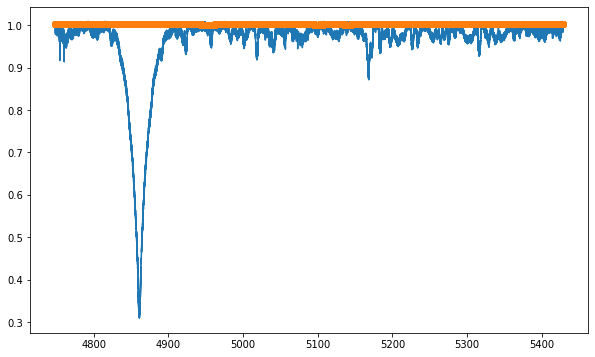

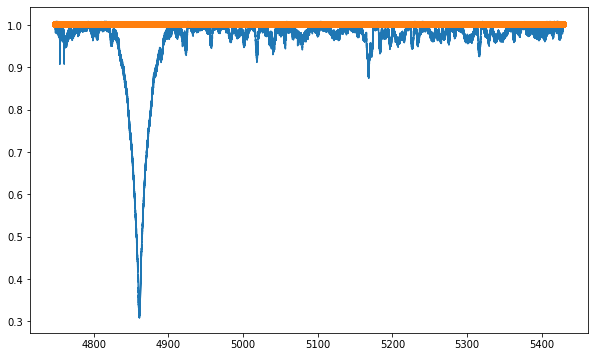

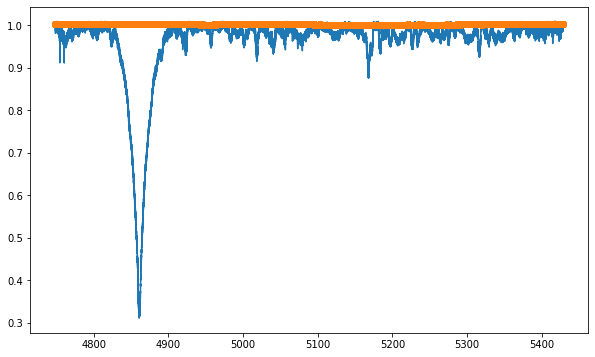

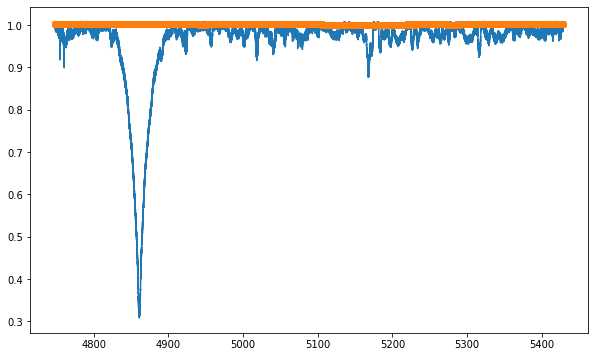

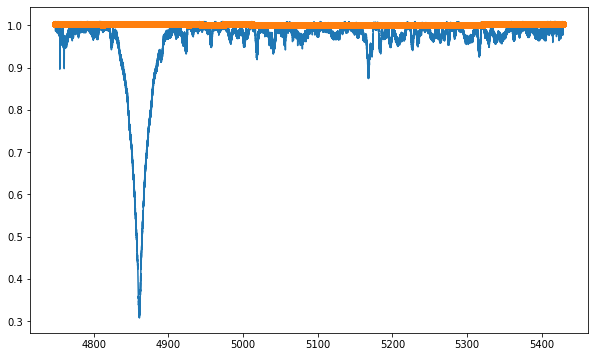

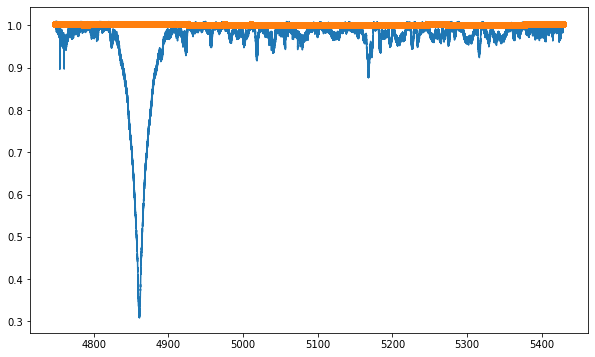

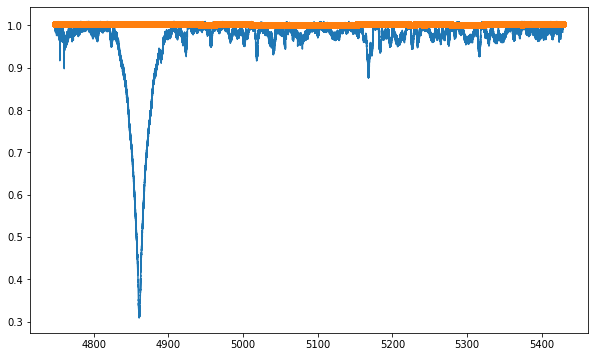

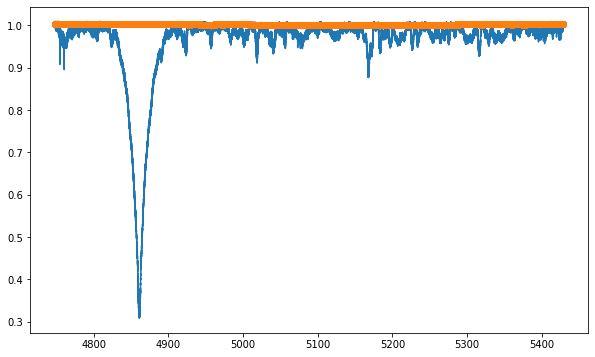

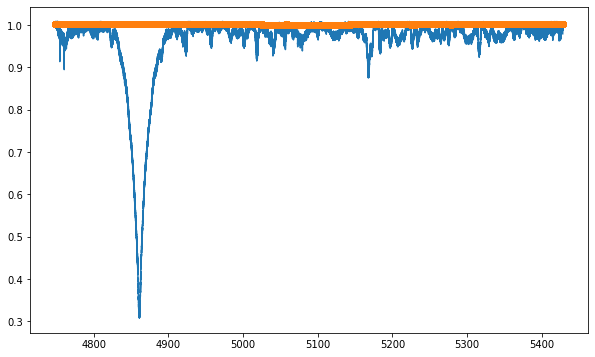

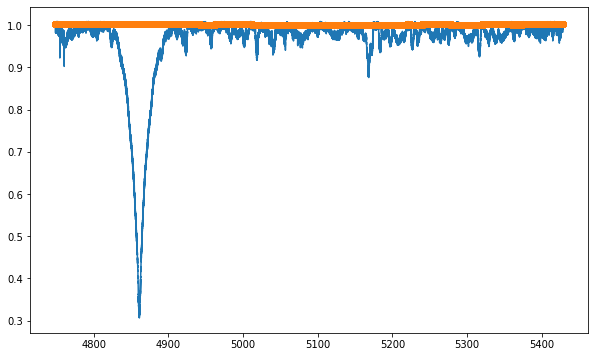

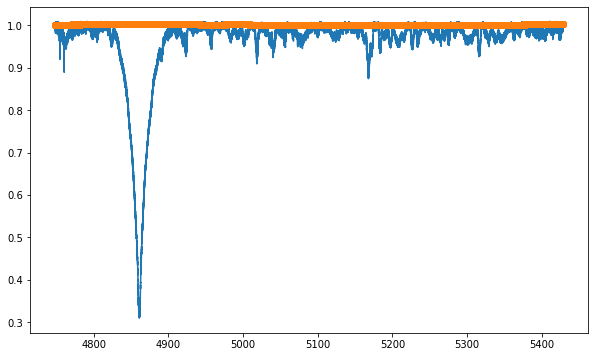

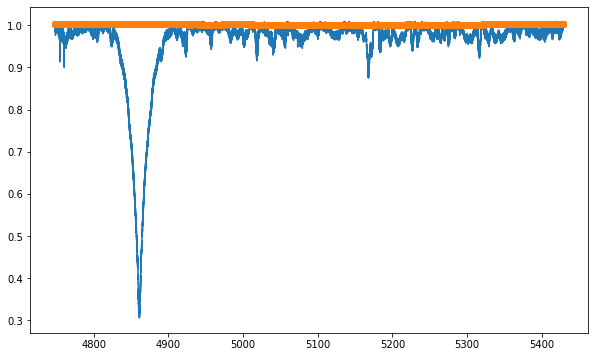

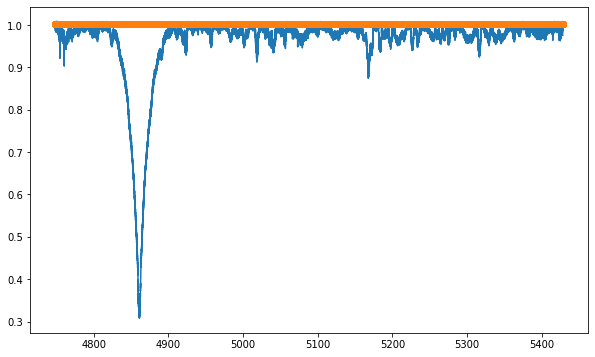

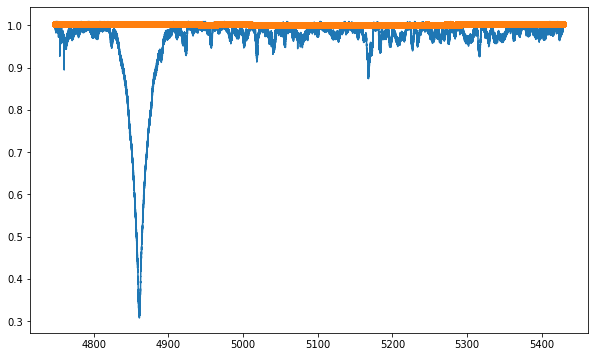

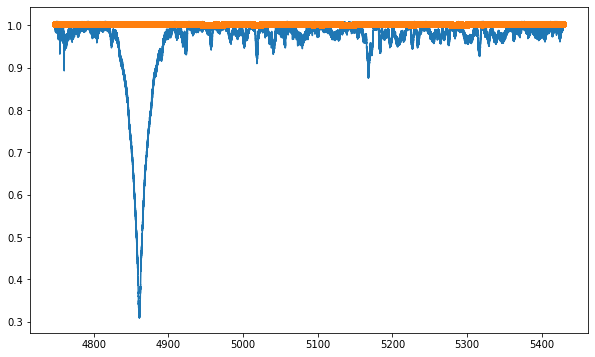

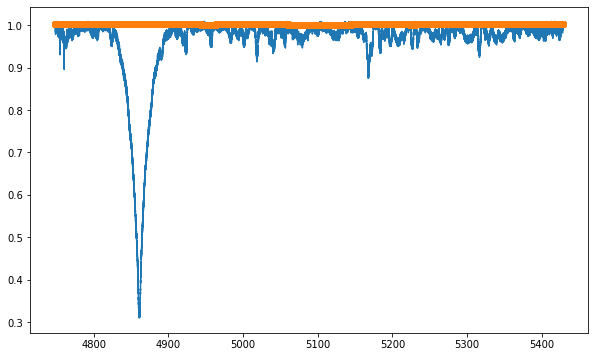

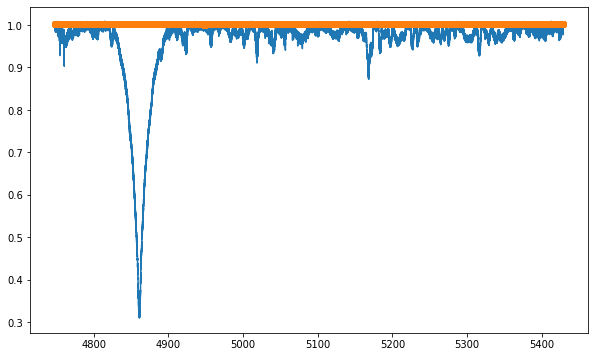

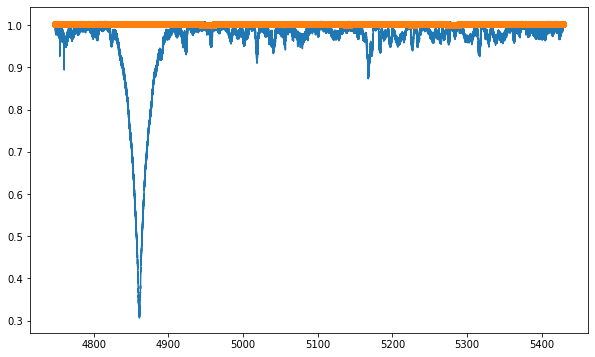

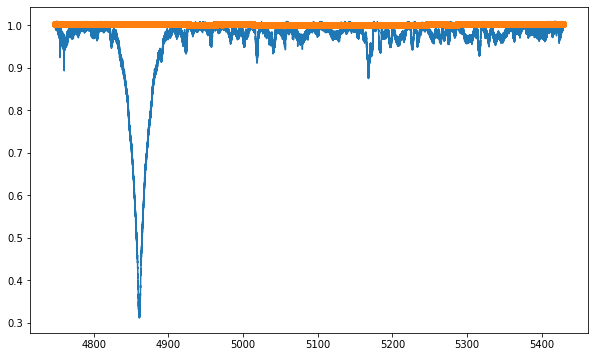

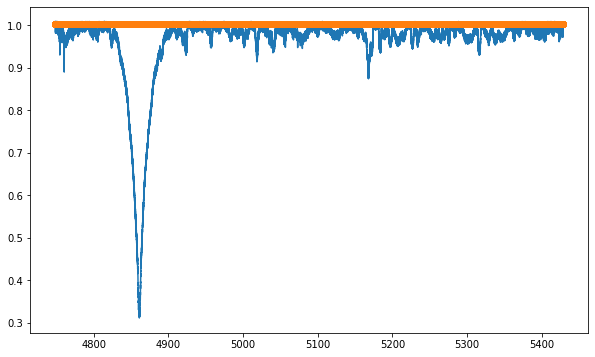

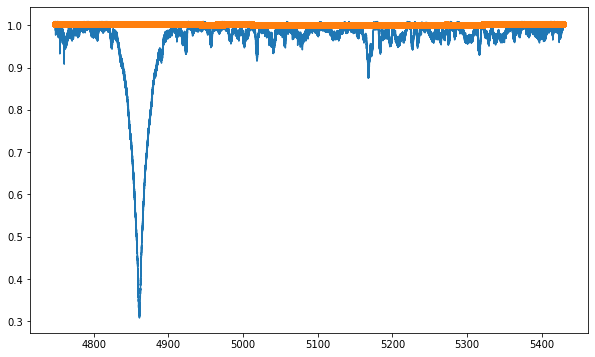

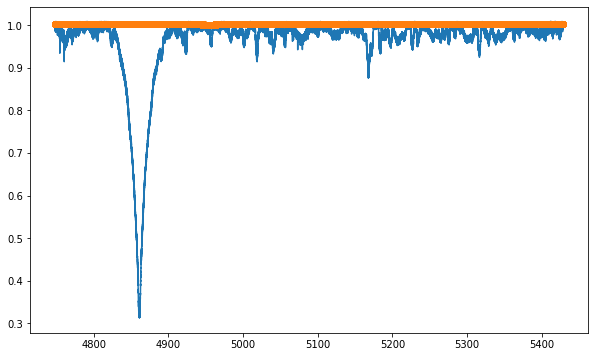

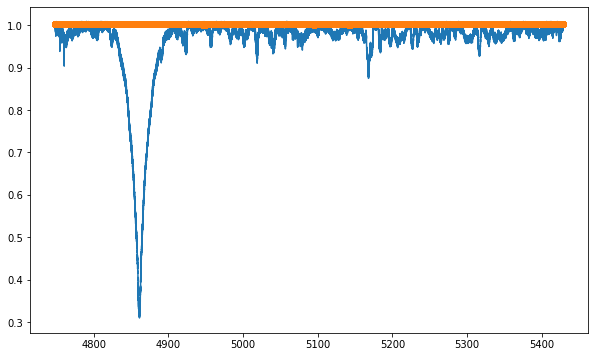

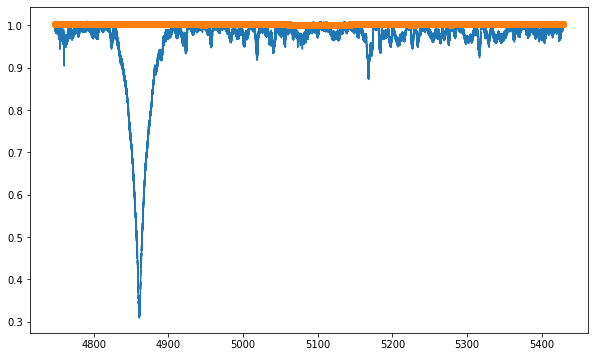

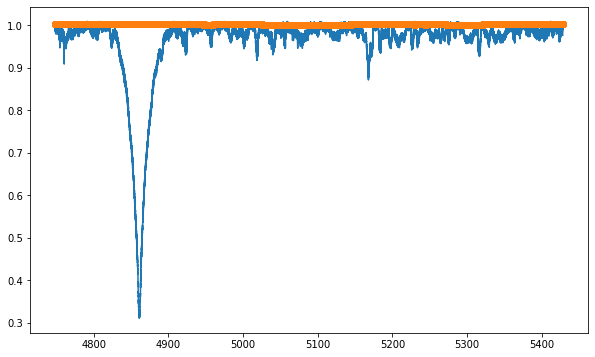

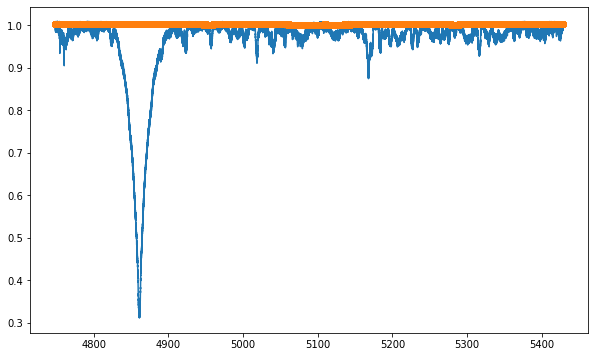

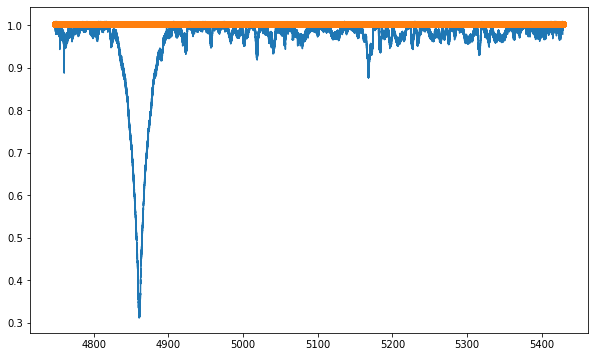

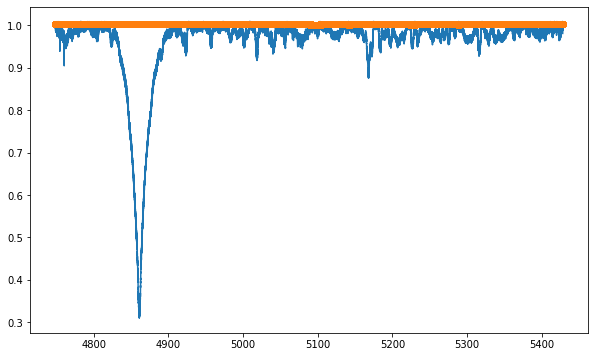

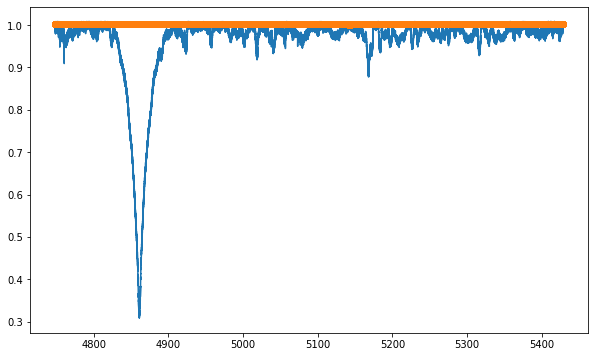

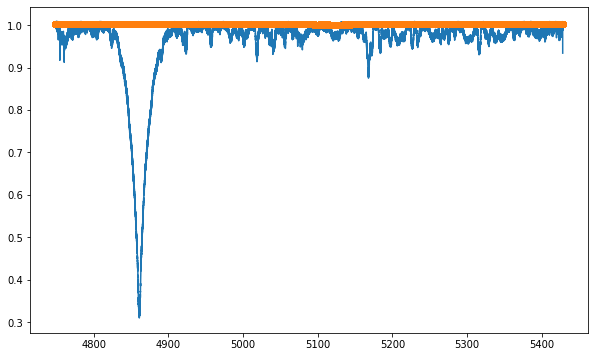

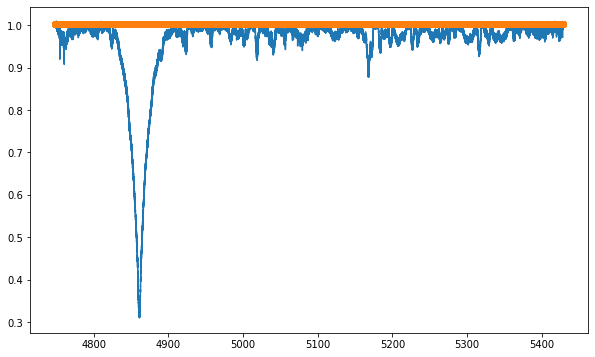

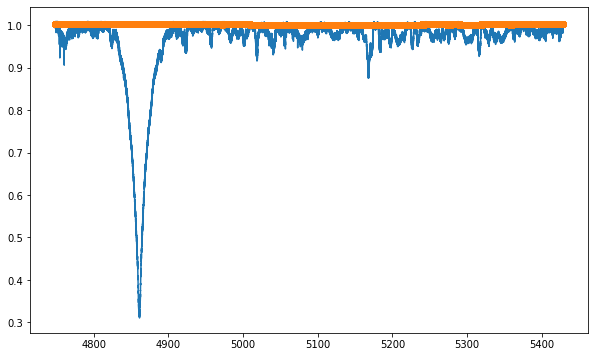

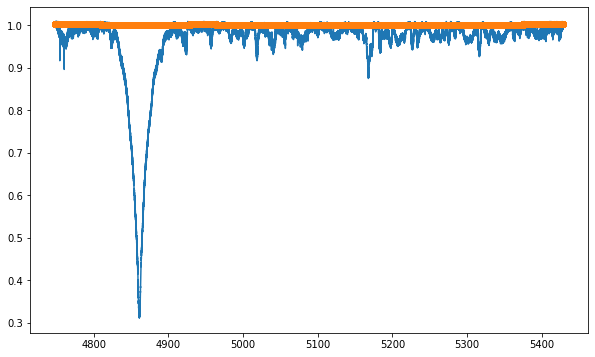

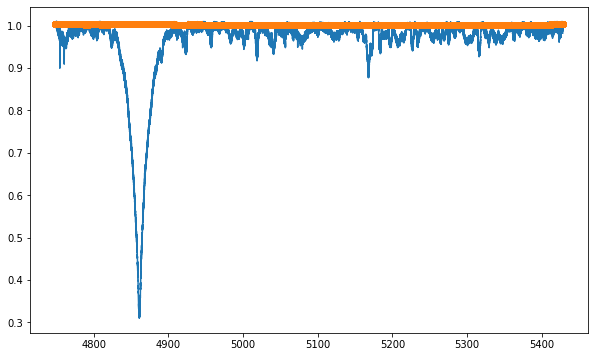

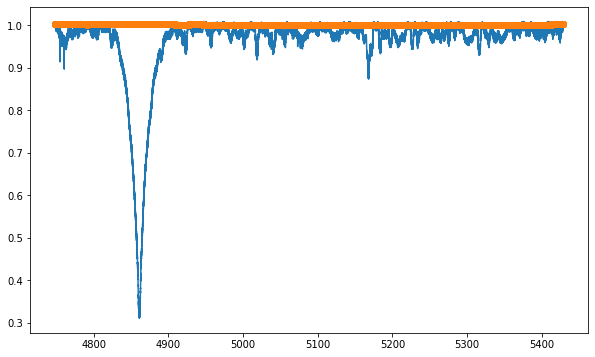

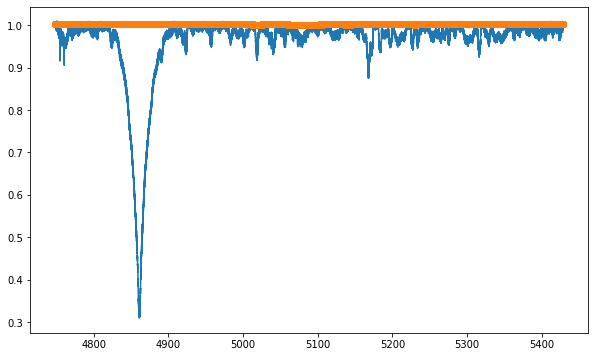

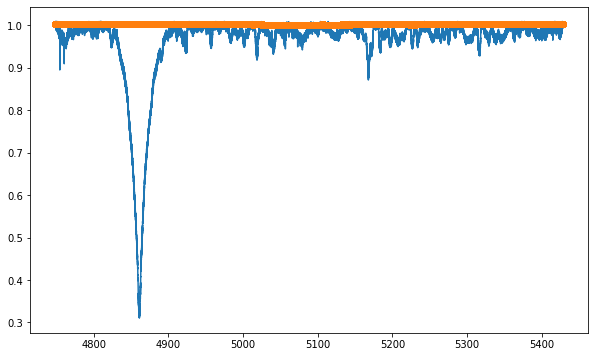

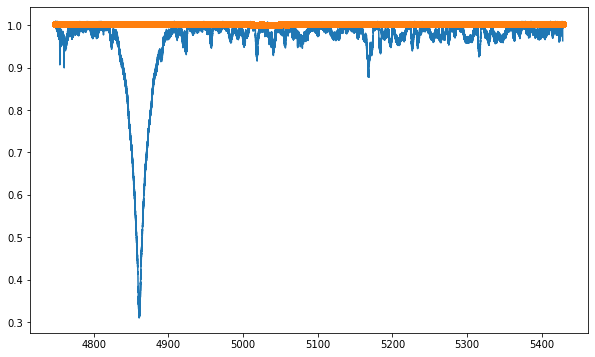

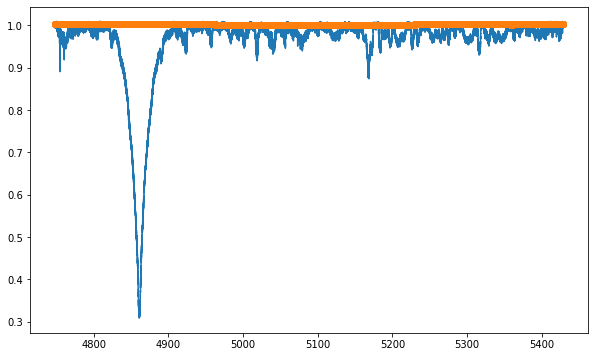

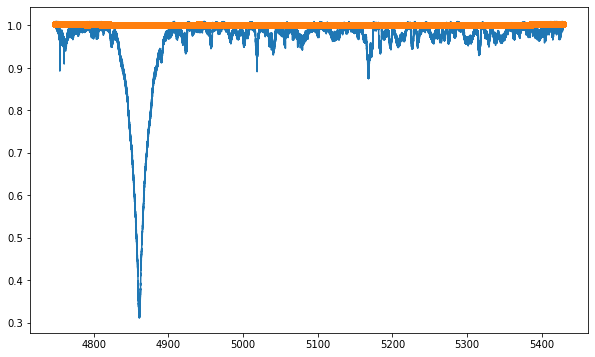

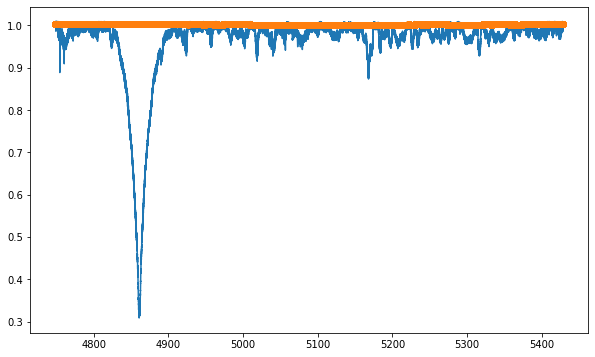

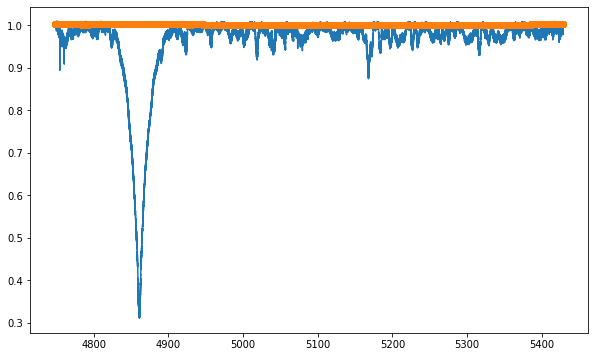

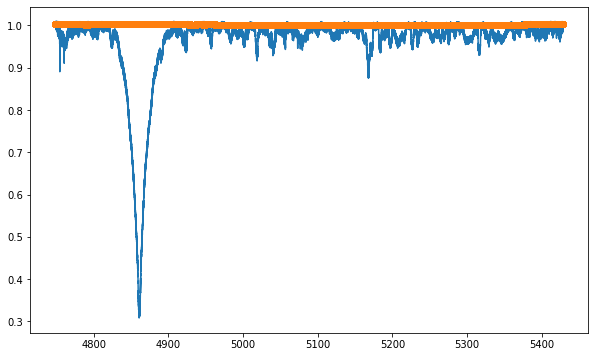

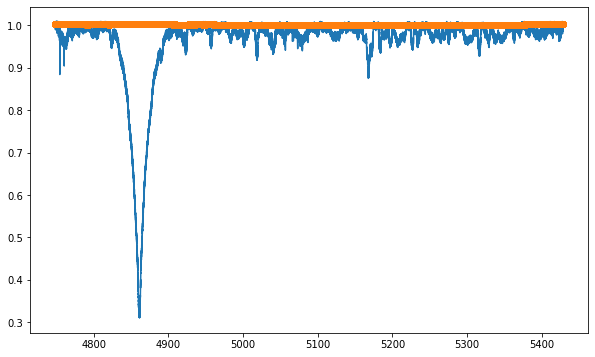

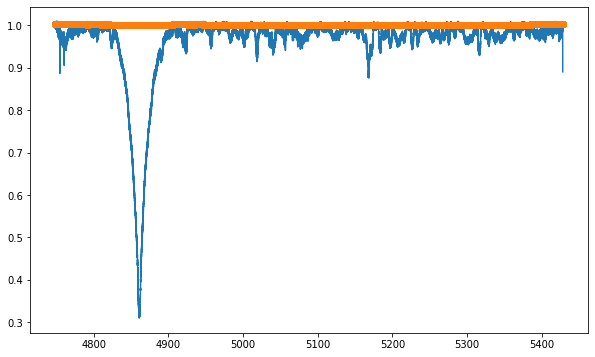

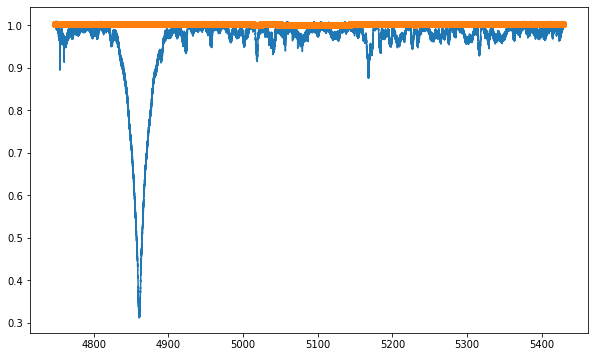

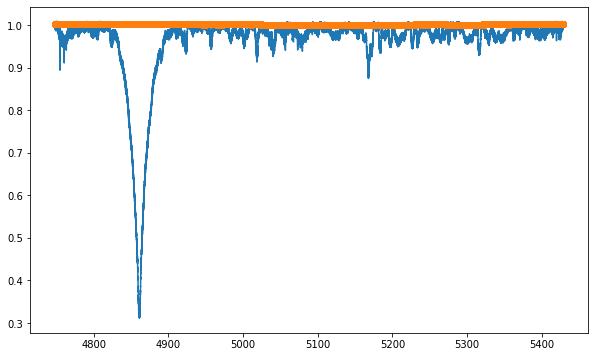

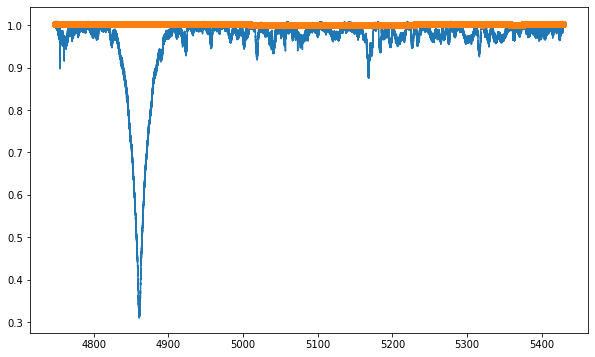

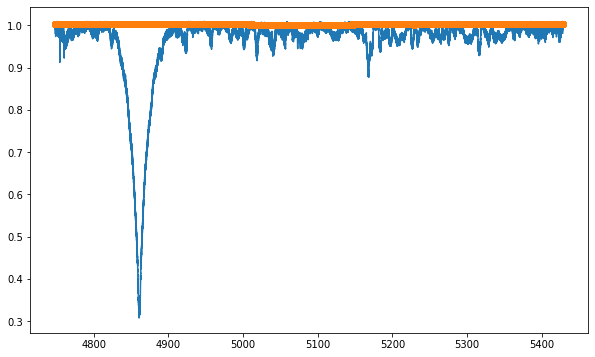

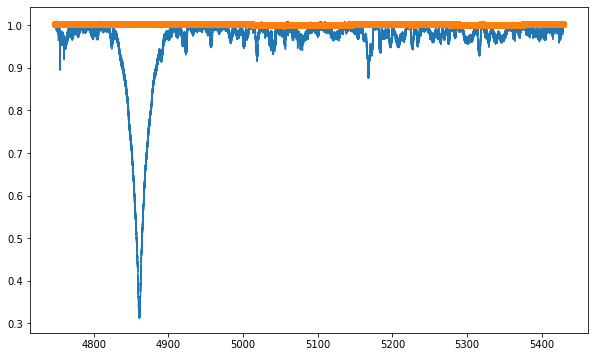

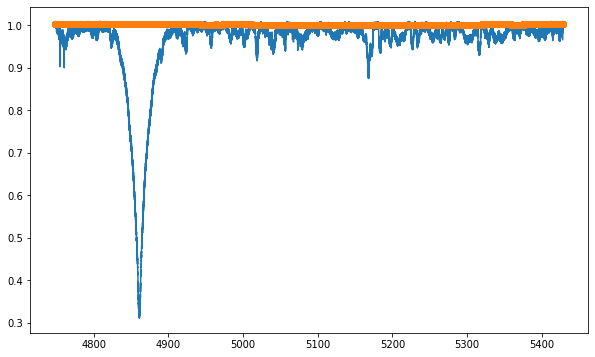

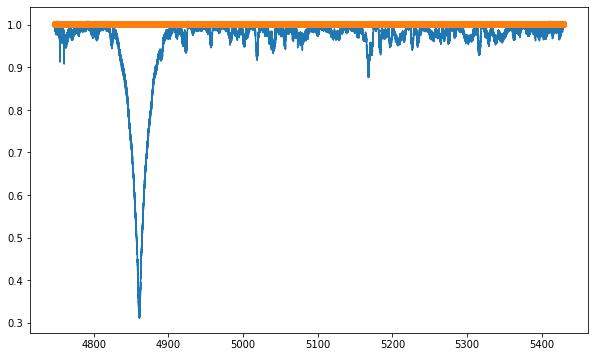

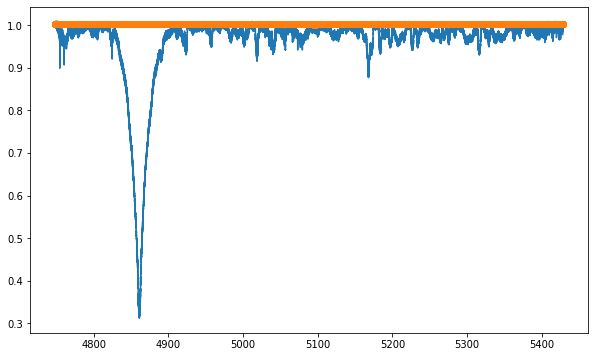

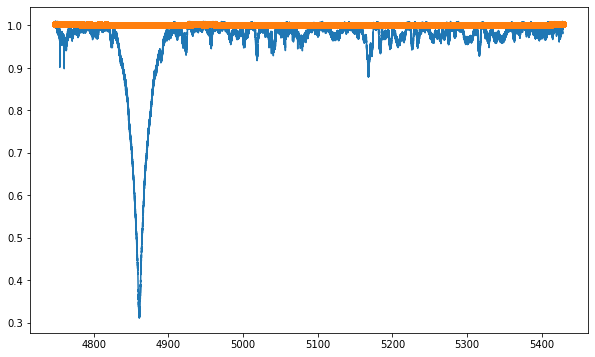

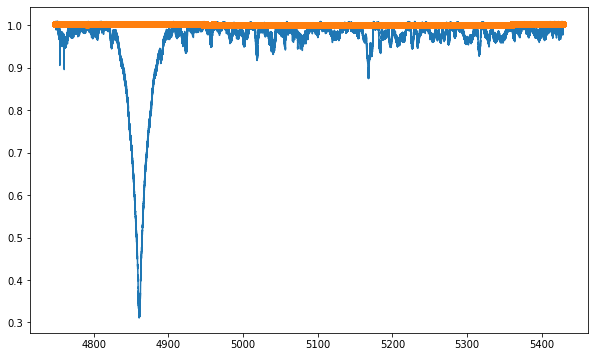

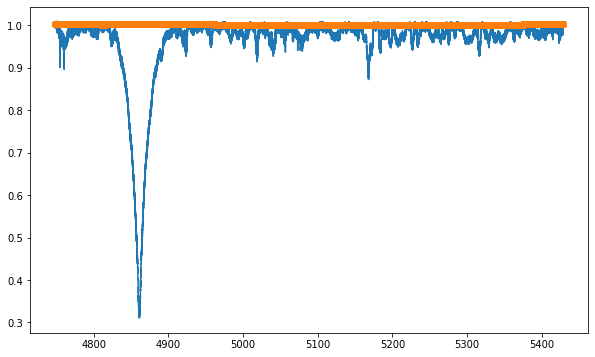

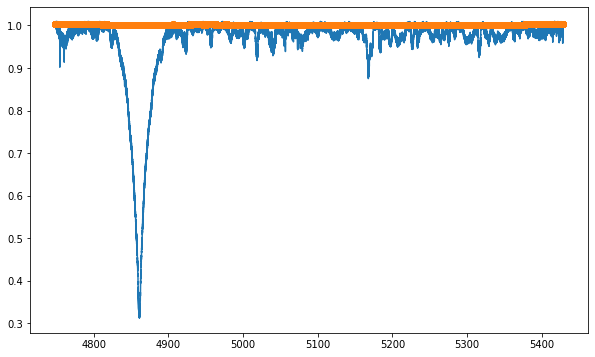

Saved.


In [9]:
# Clip spectra
print('Clipping...')
FM.sigmaClipSpectra(10)

# Normalize spectra
print('Normalizing...')
exclude = np.array([[4850,4870], [5160,5190]])*u.Angstrom # H-beta, Mg I triplet
FM.normSpectra(method='mean_filt', cutoff=0.1, filt_size=int(len(FM.wav)/200)*2+1, exclude=exclude)

# Save stellar spectrum Flux Map object with pickle
TSL.save_object(FM, 'data/'+planet_name_ref+'/'+planet_name+'/'+planet_name+'_stellar.pkl')
print('Saved.')

Make transmission spectra

Constructing transmission spectra...


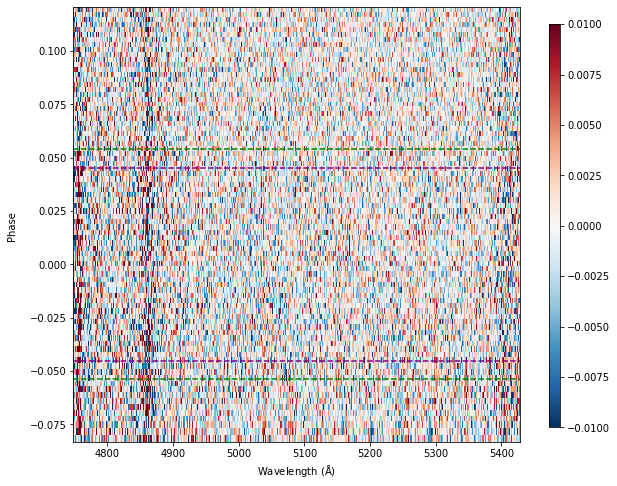

Saved.


In [10]:
print('Constructing transmission spectra...')
FM.makeTransSpectra()

vrange=[-0.01, 0.01]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(FM.wav.value, FM.phaseFold().value, FM.fluxes, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
# plt.xlim(vel_range[0], vel_range[1])
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
fig.text(0.01, 0.5, 'Phase', va='center', rotation='vertical')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

TSL.save_object(FM, 'data/'+planet_name_ref+'/'+planet_name+'/'+planet_name+'_transmission.pkl')
print('Saved.')